<a href="https://colab.research.google.com/github/lingchm/datascience-projects/blob/master/P6_kaggle_talkingdata_adtracking_frauddetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/overview

# Introduction

<p>This is an task to predict whether the APP will be installed (is_attributed=True) after user click the AD. The data-set is un-balanced (`positive/negative = 0.03/1`) and is too big for single-server environment. Belows are the challenge and solutions during the model training.</p>

* **Memore Insufficient when Data Loading**: the data-set is too large to load into memory, thus the data is partioned before feature-extraction and down-sampling. And then the down-sampled data are merged together as the training set<br/>
* **Model Evaluation**: If fill down-sampled data into the verification-set, it can not reflect the real performace in production. Thus the original data, i.e non-down-sampled data, is used as the verification set in parameter search and model evaluation. Also a function is writen to support this kind of parameter search
* **Parameter Change Trace**: Simple common code is implemented to trace base-line models and experiments (parameter-serch) base on these baselines.
* **Feature Selections**: basically is based on the feature-importency. Since the testing-set is hour-based (only several hour data), the day-based feature will be in-consistent between training set and testing set. Thus, the features are only aggregated by hour or by all-data, not by day. 

> 任务目标是在一个单机环境难以承载的不平衡数据集（正例/负例 = 0.03/1）上预测一次广告点击（AdClick）是否可以带来APP下载安装。以下是所面临的挑战和解决办法：<br/>
> 
> * **数据集载入时的内存问题**：该数据集样本数量充足，但无法载入内存，为了充分使用稀缺的正例样本，对训练集采用了“文件分桶 -> 特征提取 -> 降采样 -> 合并”的处理方式
> * **不平衡数据集模型评估**：降采样数据作为验证集的分数（虽然通常非常好）不能反映生产环境的真实效果，为了正确评估生产环境的模型效果，在搜索模型参数、评估模型时，都使用未经降采样的原始数据作为验证集。编写了简单的搜索模型参数的代码，来实现在参数搜索中有选择性地降采样。
> * **实验参数管理**：吸取前一篇[Note](https://www.kaggle.com/fangkun119/competition-mercedes-benz-greener-manufacturing)的教训，编写了简单的模型参数管理代码，用来追溯每个实验（参数搜索）以及对应的基线模型，让调参过程有迹可循
> * **特征选择**：基于lightgbm内部决策树给出的特征重要度、以及<特征-特征>、<特征-目标>相关度来选择特征等。由于竞赛给出的测试集是三个小时片段，使用天级别的特征会导致训练数据与测试数据不一致，因此剔除天级特征，只使用了多日汇总特征以及小时级特征，并让模型来决定更加倾向于哪一种特征


# libraries and Util Functions

In [ ]:
# python util
import os
import gc
from operator import methodcaller

# data processing
import numpy  as np
import pandas as pd
from sklearn.preprocessing import RobustScaler as RobustScaler
from scipy.stats import skew, norm
from scipy.stats import boxcox_normmax, boxcox
from scipy.special import boxcox1p

# lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# plot
import matplotlib.pyplot as plt 
import seaborn as sns 

# random seed
# import random
# random.seed(567)

Util funtions 

```python
g_enable_log = True
def log(log_str)
def g() #short-cut of gc.collect()
def delete(*obj_list)
def robust_boxcox(data:pd.Series, lmbda=None)
def robust_inv_boxcox(data:pd.Series, lmbda)
@contextmanager
def timer_memory(name)
```

In [ ]:
g_enable_log = True
def log(log_str):
    if g_enable_log:
        print(log_str)

def g():
    return gc.collect()

def delete(*obj_list):
    for obj in obj_list:
        del obj
    gc_cnt = g()
    if gc_cnt > 0:
        log("unreachable_obj_found: {}".format(gc_cnt))

#reference:
#https://stackoverflow.com/questions/47213443/divide-by-zero-encountered-in-log-scipy-stats-boxcox
def init_robust_boxcox():
    from scipy.special import inv_boxcox
    from scipy.stats   import boxcox

    def robust_boxcox(data:pd.Series, lmbda=None):
        if lmbda is None:
            transformed, lmbda = boxcox(1 + data)
            # enhance in condition that boxcox returns 
            # a extremely close-to-zero negative float instead of return 0
            if lmbda <= 0:
                lmbda = 0
                transformed = np.log1p(data) #log(1+data)
            return (transformed, lmbda)
        else:
            if lmbda <= 0:
                lmbda = 0
                transformed = np.log1p(data) #log(1+data)
                return (transformed, lmbda)
            else:
                transformed = boxcox(1 + data, lmbda)
            return (transformed, lmbda)

    def robust_inv_boxcox(data:pd.Series, lmbda):
        if lmbda <= 0:
            return np.expm1(data) #inv of log1p
        else:
            transformed = inv_boxcox(data, lmbda) - 1
        return transformed
    
    return robust_boxcox, robust_inv_boxcox

robust_boxcox, robust_inv_boxcox = init_robust_boxcox()

import time
import psutil
from contextlib import contextmanager    
@contextmanager
def timer_memory(name):
    t0 = time.time()
    yield
    print(f'Memory: {(psutil.Process(os.getpid()).memory_info().rss/2**30):.02f}GB')
    print(f'{name} done in {time.time()-t0:.0f}s')

# Input Files

<p>Input Files </p>
<li>train.csv: training set, the 1st column is IP, records are sorted by click_time</li>
<li>test.csv: testing set, the 1st column is click_id (from 0 to record_num-1), 2nd column is IP, sorted by click_time</li>
<p></p>

> 项目文件：
> <li>train.csv: 训练集数据, 第1列是IP，按click_time排序</li>
> <li>test.csv: 测试集数据，第1列是click_id，第2列是IP</li>

In [ ]:
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
!head -n3 ./kaggle/input/talkingdata-adtracking-fraud-detection/train.csv
!head -n3 ./kaggle/input/talkingdata-adtracking-fraud-detection/test.csv        

./kaggle/input/.DS_Store
./kaggle/input/talkingdata-adtracking-fraud-detection/.DS_Store
./kaggle/input/talkingdata-adtracking-fraud-detection/sample_submission.csv
./kaggle/input/talkingdata-adtracking-fraud-detection/test.csv
./kaggle/input/talkingdata-adtracking-fraud-detection/test_supplement.csv
./kaggle/input/talkingdata-adtracking-fraud-detection/train.csv
./kaggle/input/talkingdata-adtracking-fraud-detection/train_sample.csv
./kaggle/input/test/.DS_Store
./kaggle/input/train/.DS_Store
ip,app,device,os,channel,click_time,attributed_time,is_attributed
83230,3,1,13,379,2017-11-06 14:32:21,,0
17357,3,1,19,379,2017-11-06 14:33:34,,0
click_id,ip,app,device,os,channel,click_time
0,5744,9,1,3,107,2017-11-10 04:00:00
1,119901,9,1,3,466,2017-11-10 04:00:00


<p>Data Partitioning</p>
1. split the dataset into 20 partitions according to the value of IP % 20, which is named as IPBucket
2. each bucket is smaller enough to be loaded into memory, now we can add whatever features we want to try without worrying about the memory usage
3. down-sample the training set to balance the data-set. Since majory(is_attributed=1)/minority(is_attributed=0) is 99.7/0.3, down-sample will reduce training set to 0.3% as before as the same time
4. fit model with down-sampled training-set (the verification-set and testing-set won't be down-sampled)
    
> 数据分桶
> * 按照IP%20将数据集分成20个桶，提取特征；随后对训练集进行降采样、使得样本标签(is_attributed)分布均衡，同时也降低了训练集的数据量
> * 用降采样的训练集、以及保持原始分布(未经过降采样)的验证集训练模型；测试集则用于提交最终预测结果 <br/>
> 以下是数据分桶的代码

In [ ]:
%%time
# create directories and make sure they are empty
!cd ./kaggle/input/
!mkdir -p ./kaggle/input/train ./kaggle/input/test 
!rm -f ./kaggle/input/train/*  ./kaggle/input/test/*

# full data with 20 bucket 
# write column names into each file
!for i in $(seq 0 19); do head -n1 './kaggle/input/talkingdata-adtracking-fraud-detection/train.csv' > ./kaggle/input/train/train_${i}.csv; done
!for i in $(seq 0 19); do head -n1 './kaggle/input/talkingdata-adtracking-fraud-detection/test.csv'  > ./kaggle/input/test/test_${i}.csv; done
# split the data set according to IP(1st column of train.csv, 2nd column of test.csv) % 20
!cat './kaggle/input/talkingdata-adtracking-fraud-detection/train.csv' | grep -v '^[a-zA-Z]' | awk -F"," '{print $0 >> "./kaggle/input/train/train_"$1%20".csv"}'
!cat './kaggle/input/talkingdata-adtracking-fraud-detection/test.csv'  | grep -v '^[a-zA-Z]' | awk -F"," '{print $0 >> "./kaggle/input/test/test_"$2%20".csv"}'


awk: syntax error at source line 1
 context is
	{print $0 >> >>>  "kaggle/input/train/train_"$ <<< 1%20".csv"}
awk: illegal statement at source line 1
^C
awk: syntax error at source line 1
 context is
	{print $0 >> >>>  "kaggle/input/test/test_"$ <<< 2%20".csv"}
awk: illegal statement at source line 1
==> ./kaggle/input/train/train_0.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed

==> ./kaggle/input/train/train_1.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed

==> ./kaggle/input/train/train_10.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed

==> ./kaggle/input/train/train_11.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed

==> ./kaggle/input/train/train_12.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed

==> ./kaggle/input/train/train_13.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed

==> ./kaggle/input/train/train_14.csv <==
ip,

CPU times: user 1.79 s, sys: 490 ms, total: 2.29 s
Wall time: 2min 11s


In [ ]:
# configurations for next steps
g_ip_bkt_num = 20          # partition number
g_vldt_set_size = 5000000  # validation set size
g_is_down_sample = True    # configration to enable the tain-set down-sample
g_majority_multiply = 1    # configration to decide majority record numbers after down sample 
                           # 1: means majority_record_number = minority_record_number
                           # 2: means majority_record_number = minority_record_number * 2
g_scale_pos_weight = 1     # positive example weight (use to set scale_pos_weight parameter of lightgbm)
                           # integer: positive example weight = g_s negative example
                           # none: won't set scale_pos_weight, 
                           #       but set is_unbalanced=True to let lightgbm decide the weight by itself
# check data
!head -n3 ./kaggle/input/train/* ./kaggle/input/test/*  # first 3 lines of each file
!ls   -lh ./kaggle/input/train/* ./kaggle/input/test/*  # file size
!wc   -l  ./kaggle/input/train/* ./kaggle/input/test/*  # record numbers of each file

==> ./kaggle/input/train/train_0.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed
16760,3,1,15,379,2017-11-06 14:56:12,,0
110980,64,1,49,459,2017-11-06 15:40:30,,0

==> ./kaggle/input/train/train_1.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed
114221,3,1,19,379,2017-11-06 14:37:59,,0
105861,3,1,13,379,2017-11-06 14:38:51,,0

==> ./kaggle/input/train/train_10.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed
83230,3,1,13,379,2017-11-06 14:32:21,,0
35810,3,1,13,379,2017-11-06 14:34:12,,0

==> ./kaggle/input/train/train_11.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed
109591,3,1,19,379,2017-11-06 15:30:16,,0
109591,3,1,19,379,2017-11-06 15:39:16,,0

==> ./kaggle/input/train/train_12.csv <==
ip,app,device,os,channel,click_time,attributed_time,is_attributed
153492,3,1,17,379,2017-11-06 15:03:11,,0
90452,64,1,17,459,2017-11-06 15:08:11,,0

==> ./kaggle/input/train/train_13.csv <==
ip,app,

 9118953 ./kaggle/input/train/train_0.csv
 8980354 ./kaggle/input/train/train_1.csv
 8085680 ./kaggle/input/train/train_10.csv
 8650534 ./kaggle/input/train/train_11.csv
 9409388 ./kaggle/input/train/train_12.csv
 9304135 ./kaggle/input/train/train_13.csv
 10972873 ./kaggle/input/train/train_14.csv
 10453253 ./kaggle/input/train/train_15.csv
 10170495 ./kaggle/input/train/train_16.csv
 8533679 ./kaggle/input/train/train_17.csv
 8102341 ./kaggle/input/train/train_18.csv
 8934974 ./kaggle/input/train/train_19.csv
 9398870 ./kaggle/input/train/train_2.csv
 8820327 ./kaggle/input/train/train_3.csv
 8838671 ./kaggle/input/train/train_4.csv
 9205692 ./kaggle/input/train/train_5.csv
 8498192 ./kaggle/input/train/train_6.csv
 9990622 ./kaggle/input/train/train_7.csv
 9968884 ./kaggle/input/train/train_8.csv
 9465993 ./kaggle/input/train/train_9.csv
  901122 ./kaggle/input/test/test_0.csv
  894716 ./kaggle/input/test/test_1.csv
  844948 ./kaggle/input/test/test_10.csv
  887875 ./kaggle/input/te

If don't want to partition these data, or just want to use a small dataset to debug the program, we can un-comment the code below.

In [ ]:
#%%time
#!cd /kaggle/input/
#!mkdir -p /kaggle/input/train /kaggle/input/test 
#!rm -f /kaggle/input/train/*  /kaggle/input/test/*

#debug with 45000 data with 1 bucket
#!for i in $(seq 0 0); do head -n1 '/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv' > /kaggle/input/train/train_${i}.csv; done
#!for i in $(seq 0 0); do head -n1 '/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv'  > /kaggle/input/test/test_${i}.csv; done
#!tail -n 45000 '/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv' | grep -v '^[a-zA-Z]' | awk -F"," '{print $0 >> "/kaggle/input/train/train_"$1%1".csv"}'
#!cat '/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv'  | grep -v '^[a-zA-Z]' |awk -F"," '{print $0 >> "/kaggle/input/test/test_"$2%1".csv"}'
#g_ip_bkt_num = 1
#g_vldt_set_size = 50 
#g_is_down_sample = True
#g_scale_pos_weight = 1
#g_majority_multiply = 1

#latest 30000000 data with 1 bucket
#!for i in $(seq 0 0); do head -n1 '/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv' > /kaggle/input/train/train_${i}.csv; done
#!for i in $(seq 0 0); do head -n1 '/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv'  > /kaggle/input/test/test_${i}.csv; done
#!tail -n 30000000 '/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv' | grep -v '^[a-zA-Z]' >> "/kaggle/input/train/train_0.csv" 
#!cat '/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv'  | grep -v '^[a-zA-Z]' >> "/kaggle/input/test/test_0.csv"
#g_ip_bkt_num = 1
#g_vldt_set_size = 5000000
#g_is_down_sample = False
#g_scale_pos_weight = 99.7
#g_majority_multiply = 1

#check data
#!head -n3 /kaggle/input/train/* /kaggle/input/test/*
#!ls -lh /kaggle/input/train/* /kaggle/input/test/*
#!wc -l /kaggle/input/train/* /kaggle/input/test/*

# Feature Engineering

```python
# feature_name -> scaler
g_scaler_dict  = {}
# feature_name -> lmbda
g_boxcox_lmbda_dict = {} 
def box_cox_trans(df, fea_name, sv_policy)
def scaler_trans(df, fea_name, sv_policy, scaler)```

In [ ]:
g_scaler_dict  = {}      # feature_name -> scaler
g_boxcox_lmbda_dict = {} # feature_name -> lmbda

def box_cox_trans(df, fea_name, sv_policy):
    '''sv_policy (lmbda saving policy): new_and_save, reuse, new'''
    df[fea_name] = df[fea_name].astype('float64'); g()
    df.loc[df[fea_name] <= 0, (fea_name)] = 0.000001
    if sv_policy == 'new_and_save':
        df[fea_name], lmbda = robust_boxcox(df[fea_name]); g()
        g_boxcox_lmbda_dict[fea_name] = lmbda
    elif sv_policy == 'reuse':
        lmbda = g_boxcox_lmbda_dict[fea_name]
        df[fea_name], lmbda = robust_boxcox(df[fea_name], lmbda); g()
    else:
        df[fea_name], lmbda = robust_boxcox(df[fea_name]); g()
    log("\tboxcox lmbda: {}".format(lmbda))
    return df[fea_name].astype('float32')

def scaler_trans(df, fea_name, sv_policy, scaler):
    '''sv_policy (scaler saving policy): new_and_save, reuse, new'''    
    df[fea_name]   = df[fea_name].astype('float64'); g()
    if sv_policy == 'new_and_save':
        df[[fea_name]] = scaler.fit_transform(df[[fea_name]]); g()
        g_scaler_dict[fea_name] = scaler
    elif sv_policy == 'reuse':
        df[[fea_name]] = g_scaler_dict[fea_name].transform(df[[fea_name]]); g()
    else: #'new'
        df[[fea_name]] = scaler.fit_transform(df[[fea_name]]); g()
    return df[fea_name].astype('float32') 

<p> functions for creating new features </p>
> 用于提取特征的函数

```python
def add_grp_count(df, group_columns, dtype='uint32', scl=None, bc=False, sv='reuse')
def add_grp_stat(df, group_columns, stat_column, stat_fun_name, dtype, scl=None, bc=False, sv='reuse')
def add_grp_nxt_clk_intv(df, group_columns, scl=None, bc=False, sv='reuse')```

In [ ]:
# parameters of below functions:
# scl : scaler object
# bc  : is_boxcox, whether enable boxcox transform
# sv  : how to get transformer when boxcox tranforming and scaling
#       'new': create new transformer
#       'new_and_save': create new transformer and save it for future
#       'reuse': reuse existing transformer

def add_grp_count(df, group_columns, dtype='uint32', scl=None, bc=False, sv='reuse'):
    '''
    steps: 
    1. group DataFrame(df) by group_columns
    2. get the group size
    3. attach group size to each rows
    '''
    # parameters
    scaler            = scl
    is_boxcox         = bc
    save_transformer  = sv    
    # feature name
    feature_name = "cnt_grp_by_" + "_".join(group_columns)
    print("add feature: ", feature_name)
    # group-count
    group_col_and_cnt = df.groupby(group_columns).size().astype(dtype); g()
    # format-conversion
    group_col_and_cnt = group_col_and_cnt.rename(feature_name).to_frame().reset_index(); g()
    # merge
    df_tmp = df.merge(group_col_and_cnt, on=group_columns, how='left'); delete(df)
    df = df_tmp
    # boxcox
    if is_boxcox:
        df[feature_name] = box_cox_trans(df, feature_name, sv_policy=sv); g()
    # scaler
    if scaler is not None: #1
        df[feature_name] = scaler_trans(df, feature_name, sv_policy=sv, scaler=scaler); g() 
    # return
    print(f'\t{feature_name}: max={df[feature_name].max()}; min={df[feature_name].min()}; mean={df[feature_name].mean()}')
    return df

def add_grp_stat(df, group_columns, stat_column, stat_fun_name, dtype, scl=None, bc=False, sv='reuse'):
    '''
    steps:
    1. group DataFrame(df) by group_columns 
    2. apply stat_fun_name on stat_column in each group
    3. attach stat_func_name's ouput to each rows
    stat_func_nane: "cumcount", "var", "count", "nunique"
    '''
    # parameters
    scaler           = scl
    is_boxcox        = bc
    save_transformer = sv    
    # feature name
    feature_name = stat_fun_name + "_on_" + stat_column + "_grp_by_" + "_".join(group_columns)
    print("add feature: ", feature_name)
    # group then stat in each group
    grouped      = df[group_columns + [stat_column]].groupby(group_columns); g()
    stat_applied = methodcaller(stat_fun_name)(grouped[stat_column]).astype(dtype); g()
    delete(grouped)
    if stat_fun_name == "var":
        stat_applied = stat_applied.transform(lambda x: x.fillna(0)); g()
    # data frame conversion
    group_columns_and_stat_column = stat_applied.rename(feature_name).to_frame()
    delete(stat_applied)
    # merge
    if stat_fun_name == "cumcount": 
        df[feature_name] = group_columns_and_stat_column[feature_name].astype(dtype); g()
    elif stat_fun_name in ['var', 'count', 'nunique']:
        group_columns_and_stat_column = group_columns_and_stat_column.astype(dtype); g()
        group_columns_and_stat_column = group_columns_and_stat_column.reset_index(); g()
        df_tmp = df.merge(group_columns_and_stat_column, on=group_columns, how='left')
        delete(df)
        df = df_tmp
    else:
        raise Exception('un-supported stat_fun_name: {}'.format(stat_fun_name))  
    # boxcox transform and scaler
    if is_boxcox:
        df[feature_name] = box_cox_trans(df, feature_name, sv_policy=sv); g()
    if scaler is not None: #2
        df[feature_name] = scaler_trans(df, feature_name, sv_policy=sv, scaler=scaler); g()
    print(f'\t{feature_name}: max={df[feature_name].max()}; min={df[feature_name].min()}; mean={df[feature_name].mean()}')        
    return df

def add_grp_nxt_clk_intv(df, group_columns, scl=None, bc=False, sv='reuse'):
    '''
    add column by grouping then calculate click interval 
    between the record and it's next click in the same group
    steps:
    1.group DataFrame(df) by group_columns 
    2.calculate next click_time in the same group for each given record
    3.calculate intervial between current click and it's next click in the same group
    4.merge the intervial time into the data set
    5.scale the intervial time with RobustScaler if is_scale is True
    '''
    # parameters
    scaler           = scl
    is_boxcox        = bc
    save_transformer = sv
    # feature name
    feature_name  = 'nxt_itvl_by_' + "_".join(group_columns)
    print("add feature: ", feature_name)
    # interval to next click
    df['click_time_in_sec'] = (df['click_time'].astype(np.int64)//10**9).astype(np.int32)
    df[feature_name] = (df.groupby(group_columns)['click_time_in_sec'].shift(-1) - df['click_time_in_sec']).astype(np.float32); g()
    df[feature_name] = df[feature_name].fillna(df[feature_name].mean()); g()
    print('\tfillna: {}'.format(df[feature_name].mean()))
    df.drop(['click_time_in_sec'], axis=1, inplace=True)
    # boxcox transform and scaler
    if is_boxcox:
        df[feature_name] = box_cox_trans(df, feature_name, sv_policy=sv); g()
    if scaler is not None:  #3
        df[feature_name] = scaler_trans(
            df, feature_name, sv_policy=sv, scaler=scaler); g()
    print(f'\t{feature_name}: max={df[feature_name].max()}; min={df[feature_name].min()}; mean={df[feature_name].mean()}')        
    return df

def add_grp_pre_clk_intv(df, group_columns, scl=None, bc=False, sv='reuse'):
    '''
    add column by grouping then calculate click interval 
    between the record and it's previouse click in the same group
    steps:
    1.group DataFrame(df) by group_columns 
    2.calculate previous click_time in the same group for each given record
    3.calculate the interval between click_time of the record 
      and it's previouse click_time in the same group
    4.merge the intervial time into the data set
    5.scale the intervial time with RobustScaler if is_scale is True
    '''
    # parameters
    scaler           = scl
    is_boxcox        = bc
    save_transformer = sv    
    # feature name
    feature_name     = 'pre_itvl_by_' + "_".join(group_columns)
    print("add feature: ", feature_name)
    # calculate click interval
    df['click_time_in_sec'] = (df['click_time'].astype(np.int64)//10**9).astype(np.int32)
    df[feature_name] = (df['click_time_in_sec'] - df.groupby(group_columns)['click_time_in_sec'].shift(1)).astype(np.float32); g()
    df[feature_name] = df[feature_name].fillna(df[feature_name].mean()); g()
    print('\tfillna: {}'.format(df[feature_name].mean()))
    df.drop(['click_time_in_sec'], axis=1, inplace=True)
    # boxcox transform and scaler
    if is_boxcox:
        df[feature_name] = box_cox_trans(df, feature_name, sv_policy=sv); g()       
    if scaler is not None: #4
        df[feature_name] = scaler_trans(df, feature_name, sv_policy=sv, scaler=scaler); g() 
    print(f'\t{feature_name}: max={df[feature_name].max()}; min={df[feature_name].min()}; mean={df[feature_name].mean()}')        
    return df

# reference
# help(pandas._libs.tslibs.timedeltas.Timedelta)
# help(pandas._libs.tslibs.nattype.NaTType)
# https://kapeli.com/dash_share?docset_file=Pandas&docset_name=Pandas&path=doc/reference/series.html%23timedelta-properties&platform=pandas&repo=Main&version=0.25.1

<p>extract features</p>

In [ ]:
def add_features(df, is_boxcox=False, is_scaler=False, save_transformer='reuse'):
    '''
    create extended features
    parameters:
    * save_transformer: how to get transformer when doing boxcox and scaling features
    *   'new': create new transformer
    *   'new_and_save': create new transformer and save it for future
    *   'reuse': reuse existing transformer
    '''
    # parameter short cut
    sv = save_transformer 
    bc = is_boxcox
    s  = None;
    if is_scaler:
        s = RobustScaler()
    # features and importancy
    # 2008: nxt_intv_by_ip_os_device_app
    df = add_grp_nxt_clk_intv(df, ['ip','os','device','app'], bc=None,scl=s,sv=sv);g()
    # 1747: channel
    # 1313: os
    # 1182: hh
    # 1051: app
    # 1035: cnt_grp_by_dd_hh_app_channel
    df = add_grp_count(df, ['dd','hh','app','channel'], bc=bc,scl=s,sv=sv);g()
    # 995 : cumcount_on_app_grp_by_ip_device_os
    df = add_grp_stat(df, ['ip','device','os'], 'app', 'cumcount', 'uint32', bc=bc,scl=s,sv=sv);g()
    # 990 : cnt_grp_by_ip_device
    df = add_grp_count(df, ['ip','device'], bc=bc,scl=s,sv=sv);g()
    # 929 : nunique_on_channel_by_ip
    df = add_grp_stat(df, ['ip'], 'channel', 'nunique', 'uint16',bc=None,scl=None,sv=sv);g()
    # 921 : nunique_on_app_by_ip
    df = add_grp_stat(df, ['ip'], 'app', 'nunique', 'uint16',bc=None,scl=None,sv=sv);g()
    # 835 : nxt_intv_by_ip_channel
    df = add_grp_nxt_clk_intv(df, ['ip','channel'], bc=None,scl=s,sv=sv);g()
    # 834 : cnt_grp_by_ip_hh_device
    df = add_grp_count(df, ['ip','hh','device'], bc=bc,scl=s,sv=sv);g()
    # 832 : nxt_intv_by_ip_app_channel
    df = add_grp_nxt_clk_intv(df, ['ip','app','channel'], bc=None,scl=s,sv=sv);g()
    # 825 : cnt_grp_by_app_channel
    df = add_grp_count(df, ['app','channel'], bc=bc,scl=s,sv=sv);g()
    # 716 : cnt_grp_by_ip_app
    df = add_grp_count(df, ['ip','app'], bc=bc,scl=s,sv=sv);g()
    # 635 : unique_on_app_grp_by_ip_hh
    df = add_grp_stat(df, ['ip','hh'], 'app', 'nunique','uint16',bc=bc,scl=s,sv=sv);g()
    # 592 : cnt_grp_by_ip_hh_app
    df = add_grp_count(df, ['ip','hh','app'], bc=bc,scl=s,sv=sv);g()
    # 432 : nunique_on_channel_by_app
    df = add_grp_stat(df, ['app'], 'channel', 'nunique', 'uint16',bc=None,scl=None,sv=sv);g()   
    # 422 : nunique_on_channel_by_hh_app
    df = add_grp_stat(df, ['hh','app'], 'channel', 'nunique', 'uint16',bc=None,scl=None,sv=sv);g() 
    pd.set_option('display.max_columns',100)
    print(df.head())
    # 307 : device
    return df

<p>function for random down-sampling, normal we setting majority_multiply=1 to make majority_examples_count/minority_examples_count=1, sometime we want more majority examples we can increase majority_multiply and vice versa</p>
> 用于随机降采样的函数，设置majority_multiply=1可以让majority样本数与minority样本数相同，增加majority_multiply可以增加majority样本数占比，反之亦然

```python
def random_down_sample(df, majority_multiply=1, target_col_name='is_attributed', minority_val = 1, majority_val = 0)```

In [ ]:
def random_down_sample(df, majority_multiply=1, target_col_name='is_attributed', minority_val=1, majority_val=0):
    '''
    down sample the majority part, 
    so that both part (target=1, target=0) has equal number of recordes
    '''
    minority_cnt = len((df[df[target_col_name] == minority_val])) 
    majority_cnt = (minority_cnt * majority_multiply) // 1

    shuffled = df.sample(frac=1)
    minority = shuffled.loc[shuffled[target_col_name] == minority_val]
    majority = shuffled.loc[shuffled[target_col_name] == majority_val][:majority_cnt]

    undersample_df = pd.concat([minority, majority]).sample(frac=1)
    delete(shuffled, minority, majority)
    return undersample_df

# Prepare Data Set

## configures

In [ ]:
# categorical features
g_categorical_features = ['app', 'device', 'os', 'channel', 'hh'] 

# only for extracting features, won't used in model training
g_non_train_columns    = ['click_time', 'dd', 'ip']

# file spec
def get_file_spec(is_test_file):
    dtypes = {'ip':'uint32','app':'uint16','device':'uint8','os':'uint16',
        'channel':'uint16','is_attributed':'int8','click_id':'int32'} 
    date_columns = ['click_time']
    test_file_columns  = ['click_time','ip','app','device','os','channel','click_id']
    train_file_columns = ['click_time','ip','app','device','os','channel','is_attributed']    
    if is_test_file:
        return dtypes, date_columns, test_file_columns
    else:
        return dtypes, date_columns, train_file_columns

## functions

<p>functions for preparing data set</p>

> 用于准备数据集的函数

```python
def read_data_file(file_path, is_test_file)
def process_ip_bucket(ip_bucket, is_down_sample, majority_multiply, tsfm_sv_policy) #'new_and_save','reuse','new'

# columns created in read_data_file(file_path, is_test_file)
df['dd']  = pd.to_datetime(df.click_time).dt.day.astype('uint8')  # [01, 31]
df['hh']  = pd.to_datetime(df.click_time).dt.hour.astype('uint8') # [00, 23]```

In [ ]:
def read_data_file(file_path, is_test_file):
    print('read file [is_test_file={}]: {}'.format(is_test_file, file_path))
    dtypes, date_columns, file_columns = get_file_spec(is_test_file)
    df = pd.read_csv(file_path, parse_dates=date_columns,usecols=file_columns,dtype=dtypes)
    df['dd']  = pd.to_datetime(df.click_time).dt.day.astype('uint8')  # [01, 31]
    df['hh']  = pd.to_datetime(df.click_time).dt.hour.astype('uint8') # [00, 23]
    g()
    return df

def process_ip_bucket(ip_bucket, is_down_sample, majority_multiply, tsfm_sv_policy):
    # file path
    print('---------- process bucket: {} -----------'.format(ip_bucket))
    train_file_path = 'kaggle/input/train/train_{}.csv'.format(ip_bucket)
    test_file_path  = 'kaggle/input/test/test_{}.csv'.format(ip_bucket)
    # read file
    df_test         = read_data_file(test_file_path,  is_test_file=True)    
    df_train_vldt   = read_data_file(train_file_path, is_test_file=False)
    print('read files: {}; {}'.format(train_file_path, test_file_path))
    # align columns and merge
    df_train_vldt['click_id'] = -1
    df_test['is_attributed']  = -1
    df_full  = pd.concat([df_train_vldt, df_test], sort=False)
    # train_vldt_len and nunique of raw feature
    train_vldt_len = len(df_train_vldt)
    delete(df_train_vldt, df_test)
    #print('df_full.head(n=5000000).nunique():\n', df_full.head(n=5000000).nunique()); g()
    #ip:9819; app:343; device:250; os:246; channel:169; click_time:121600; ...
    # feature process
    print('add features: ')
    df_full = add_features(df_full, save_transformer=tsfm_sv_policy); g()
    # drop non-training columns
    print('drop non-training-columns: {}'.format(g_non_train_columns))
    df_full.drop(g_non_train_columns, axis=1, inplace=True); g()
    # split into df_train, df_vldt, df_test
    print('split data set: ')
    vldt_len = min(g_vldt_set_size // g_ip_bkt_num, train_vldt_len // 5)
    df_train = df_full[: train_vldt_len - vldt_len]
    df_vldt  = df_full[train_vldt_len - vldt_len : train_vldt_len]
    df_test  = df_full[train_vldt_len :]
    # drop tmp colums created when aligning
    print('drop temporary columns: ')
    print('\tdf_train[\'click_id\'].value_counts()={}'.format(df_train['click_id'].value_counts()))
    print('\tdf_vldt[\'click_id\'].value_counts()={}'.format(df_vldt['click_id'].value_counts()))
    print('\tdf_test[\'is_attributed\'].value_counts()={}'.format(df_test['is_attributed'].value_counts()))
    df_train.drop(['click_id'], axis=1, inplace=True)
    df_vldt.drop(['click_id'], axis=1, inplace=True)
    df_test.drop(['is_attributed'], axis=1, inplace=True)
    print('shape: vldt={}; test={}'.format(df_vldt.shape, df_test.shape))
    print('shape: train(before downsample)={}'.format(df_train.shape))
    g()
    # downsample if necessary
    if is_down_sample == True:
        print('down_sample: majority_multiply={}'.format(majority_multiply))
        df_train = random_down_sample(df_train, majority_multiply)
        print('gc.collect (warnning is OK): ')
        g()
        print('shape(after downsample)={}'.format(df_train.shape))
    # return
    return df_train, df_vldt, df_test

## Prepare Data Set

> 准备数据集

```python
def prep_data_set_full_data()
def feature_target_split(df, target_col_name, inplace=False)
def prep_feature_target_full_data()
```

In [ ]:
def prep_data_set_full_data():
    log_template="append bkt {}: train.shape={}; vldt.shape={}; test.shape={}"
    df_train, df_vldt, df_test = process_ip_bucket(
                                            ip_bucket=0, is_down_sample=g_is_down_sample, 
                                            majority_multiply=g_majority_multiply, 
                                            tsfm_sv_policy='new_and_save')
    print(log_template.format(0, df_train.shape, df_vldt.shape, df_test.shape))
    for bkt_id in range(1,g_ip_bkt_num):
        train_bkt, vldt_bkt, test_bkt = process_ip_bucket(
                                            ip_bucket=bkt_id, is_down_sample=g_is_down_sample, 
                                            majority_multiply=g_majority_multiply, 
                                            tsfm_sv_policy='reuse'); g()
        df_train = df_train.append(train_bkt, ignore_index=True); g()
        df_vldt  = df_vldt.append(vldt_bkt, ignore_index=True); g()
        df_test  = df_test.append(test_bkt, ignore_index=True); g()
        delete(train_bkt, vldt_bkt, test_bkt)
        print(log_template.format(bkt_id, df_train.shape, df_vldt.shape, df_test.shape))
    df_test.set_index('click_id', drop=True, inplace=True)
    df_test.sort_index(axis=0, inplace=True)
    return df_train, df_vldt, df_test

def feature_target_split(df, target_col_name, inplace=False):
    y = df[target_col_name]; g()
    if True == inplace:
        df.drop(target_col_name, axis=1, inplace=True); g()
        X = df
    else:
        X = df.drop(target_col_name, axis=1, inplace=True); g()
    return X, y

def prep_feature_target_full_data(): 
    df_train, df_vldt, df_test = prep_data_set_full_data()
    X_train, y_train = feature_target_split(df_train, target_col_name = 'is_attributed', inplace = True)
    X_vldt,  y_vldt  = feature_target_split(df_vldt,  target_col_name = 'is_attributed', inplace = True)
    delete(df_train, df_vldt)
    print('----: prep_feature_target_full_data :-----')
    print('-- X_train={}; y_train={}; X_vldt={}; y_vldt={}; df_test={}'.format(
            X_train.shape, y_train.shape, X_vldt.shape, y_vldt.shape, df_test.shape))
    print('-- features :', X_train.columns.values.tolist())
    print('-- categorical :', g_fit_params['categorical_feature'])
    print('-- y_train.value_counts\n:', y_train.value_counts())
    print('-- y_vldt.value_countsl\n:', y_vldt.value_counts())
    return X_train, y_train, X_vldt, y_vldt, df_test

# Model and Parameters

## Model Parameters 

<p>parameters of <b>LGBMClassifier</b> constructor parameter.  there are some dicts to manage baseline model and experimental parameters (grid-search) of each baseline</p>

> 模型参数，用来追踪基线模型（base-line model）以及在基线基础上做实验（experimental model）用到的网格搜索参数

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Light Gradient Boosting Classifier Parameters
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# https://lightgbm.readthedocs.io/en/latest/Parameters.html

def default_model(): 
    lgb_default = LGBMClassifier()
    return lgb_default.set_params(
        objective          = 'binary', # for binary classification
        metric             = 'auc',    # use metric required by this contest
        boosting_type      = 'gbdt',   # gbdt, dart, goss, rf
        verbose            = 1,        # -1
        nthread            = 4,        
        iid                = False,    # return average score across folds (not weighted)
        two_round          = True 
    )

def gbtd_base_001():
    return default_model().set_params(
        subsample = 0.8,             # alias of bagging_fraction
        subsample_freq = 1,          # alias of bagging_freq
        subsample_for_bin = 200000,  # alias of bin_construct_sample_cnt
        colsample_bytree = 0.8,      # alias of feature_fraction
        learning_rate = 0.08, 
        num_leaves = 105,            # 100:v103 -> 105:v105
        max_depth = 7,
        min_split_gain = 0.3, 
        max_bin = 255,               # default 255
        reg_alpha = 0.3,  
        n_estimators = 2500          # alias of num_boost_round
    )

g_base_models = {
    'gbdt_base_001' : gbtd_base_001()
}

g_search_params = {
    # https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
    # 'gbdt_base_001_exp_001' : {'num_leaves':[90, 95, 100, 105]},   # 105
    # 'gbdt_base_001_exp_003' : {'learning_rate':[0.1, 0.08, 0.06]}, # 0.8 is the best
    # 'gbdt_base_001_exp_004' : {'max_bin':[255, 315]},              # no difference
    'gbdt_base_001_exp_002' : {'min_sum_hessian_in_leaf':[0.001, 0.01, 0.05, 0.1]}, 
    'gbdt_base_001_exp_005' : {'min_split_gain':[0.3, 0.4, 0.5]},
    'gbdt_base_001_exp_010' : {'num_leaves':[90,105], 'min_split_gain':[0.3,0.4]}
}

def update_data_balancing_param(lgb_model, y_value_counts, majority_val=0, minority_val=1):
    print('y_value_counts: \n{}'.format(y_value_counts))
    if g_scale_pos_weight is None:
        print(f'use global config: scale_pos_weight={g_scale_pos_weight}')
        lgb_model.set_params(scale_pos_weight = g_scale_pos_weight)
    else :
        unbalance_degree = y_value_counts[majority_val] / y_value_counts[minority_val]
        print(f'majority_count/minority_count={unbalance_degree}')        
        if unbalance_degree > 1.5 or unbalance_degree < 0.66:
            print(f'unbalance_dgree')
            lgb_model.set_params(is_unbalance = True)
    return lgb_model

def get_model_and_search_params(base_model_id, search_params_id):
    return g_base_models[base_model_id], g_search_params[search_params_id]

# test
# model, search_params = get_model_and_search_params('gbdt_base_001', 'gbdt_base_001_exp_001')
# print(model.get_params(), '\n', search_params)

## Fit-Parameters 

parameters of <b>LGBMClassifier.fit()</b> function

In [ ]:
g_fit_params = {
    'categorical_feature'   : g_categorical_features,
    'early_stopping_rounds' : 25,
    'verbose'               : 10,
    'eval_metric'           : 'auc'
}

## Function for fitting model

In [ ]:
def fit_model(X_train, y_train, X_validate, y_validate, lgb_model): 
    '''
    id_in_g_base_models: hash key in g_base_models, such as 'gbdt_base_001'
    '''
    # fit parameters
    cat_fea_indices = list(map(lambda col:X_train.columns.get_loc(col), g_fit_params['categorical_feature']))
    print('------ fit parameters: ---------------------')
    print('early_stopping_rounds: {}'.format(g_fit_params['early_stopping_rounds']))
    print('verbose: {}'.format(g_fit_params['verbose']))
    print('eval_metric: {}'.format(g_fit_params['eval_metric']))
    print('categorical_feature: ', cat_fea_indices)
    for i in cat_fea_indices:
        print("\t", i, ":", g_fit_params['categorical_feature'][i])
    print('------ updarte balancing parameters: ---------------------')
    lgb_model = update_data_balancing_param(lgb_model, y_train.value_counts())
    print('------ model parameters: ---------------------')    
    print(lgb_model.get_params())
    # fit model
    fitted = lgb_model.fit(X_train, y_train  
                 ,  categorical_feature   = cat_fea_indices 
                 ,  early_stopping_rounds = g_fit_params['early_stopping_rounds']
                 ,  verbose               = g_fit_params['verbose']
                 ,  eval_metric           = g_fit_params['eval_metric']
                 ,  eval_set              = [(X_validate, y_validate)])
    # return
    g()
    return fitted

# Fit Model

fetch a baseline model 

> 选取一个基线模型

In [ ]:
g_base_model = g_base_models['gbdt_base_001']

prepare dataset， including train-set, validate-set, test-set(for submit)

> 准备数据集，包括：训练集、验证集、以及用于提交模型结果的测试集

In [ ]:
with timer_memory('prep_feature_target_full_data'):
    X_train, y_train, g_X_vldt, g_y_vldt, g_df_test = prep_feature_target_full_data()

---------- process bucket: 0 -----------
read file [is_test_file=True]: kaggle/input/test/test_0.csv
read file [is_test_file=False]: kaggle/input/train/train_0.csv
read files: kaggle/input/train/train_0.csv; kaggle/input/test/test_0.csv
add features: 
add feature:  nxt_itvl_by_ip_os_device_app
	fillna: 9838.6787109375
	nxt_itvl_by_ip_os_device_app: max=340928.0; min=0.0; mean=9838.6787109375
add feature:  cnt_grp_by_dd_hh_app_channel
	cnt_grp_by_dd_hh_app_channel: max=26256; min=1; mean=3089.1630010080767
add feature:  cumcount_on_app_grp_by_ip_device_os
	cumcount_on_app_grp_by_ip_device_os: max=59029; min=0; mean=1233.6789451533937
add feature:  cnt_grp_by_ip_device
	cnt_grp_by_ip_device: max=241630; min=1; mean=20373.164897601044
add feature:  nunique_on_channel_grp_by_ip
	nunique_on_channel_grp_by_ip: max=151; min=1; mean=113.7428015743997
add feature:  nunique_on_app_grp_by_ip
	nunique_on_app_grp_by_ip: max=177; min=1; mean=63.00887199125196
add feature:  nxt_itvl_by_ip_channel
	fi

drop non-training-columns: ['click_time', 'dd', 'ip']
split data set: 
drop temporary columns: 
	df_train['click_id'].value_counts()=-1    8730353
Name: click_id, dtype: int64
	df_vldt['click_id'].value_counts()=-1    250000
Name: click_id, dtype: int64
	df_test['is_attributed'].value_counts()=-1    894715
Name: is_attributed, dtype: int64
shape: vldt=(250000, 21); test=(894715, 21)
shape: train(before downsample)=(8730353, 21)
down_sample: majority_multiply=1
gc.collect (warnning is OK): 
shape(after downsample)=(43330, 21)
append bkt 1: train.shape=(88782, 21); vldt.shape=(500000, 21); test.shape=(1795836, 21)
---------- process bucket: 2 -----------
read file [is_test_file=True]: kaggle/input/test/test_2.csv
read file [is_test_file=False]: kaggle/input/train/train_2.csv
read files: kaggle/input/train/train_2.csv; kaggle/input/test/test_2.csv
add features: 
add feature:  nxt_itvl_by_ip_os_device_app
	fillna: 9423.5673828125
	nxt_itvl_by_ip_os_device_app: max=341511.0; min=0.0; mean=9

	nunique_on_channel_grp_by_app: max=44; min=1; mean=25.469055447442145
add feature:  nunique_on_channel_grp_by_hh_app
	nunique_on_channel_grp_by_hh_app: max=36; min=1; mean=21.111041852567112
       ip  app  device  os  channel          click_time  is_attributed  dd  \
0  209663    3       1  13      379 2017-11-06 14:48:55              0   6   
1   73503    3       1  18      379 2017-11-06 14:49:43              0   6   
2   38763    3       1  13      379 2017-11-06 15:08:04              0   6   
3   38683    3       1  19      379 2017-11-06 15:08:26              0   6   
4  209663    3       1  19      379 2017-11-06 15:22:08              0   6   

   hh  click_id  nxt_itvl_by_ip_os_device_app  cnt_grp_by_dd_hh_app_channel  \
0  14        -1                        3648.0                             2   
1  14        -1                       25833.0                             2   
2  15        -1                        6089.0                            23   
3  15        -1        

drop non-training-columns: ['click_time', 'dd', 'ip']
split data set: 
drop temporary columns: 
	df_train['click_id'].value_counts()=-1    8588670
Name: click_id, dtype: int64
	df_vldt['click_id'].value_counts()=-1    250000
Name: click_id, dtype: int64
	df_test['is_attributed'].value_counts()=-1    902912
Name: is_attributed, dtype: int64
shape: vldt=(250000, 21); test=(902912, 21)
shape: train(before downsample)=(8588670, 21)
down_sample: majority_multiply=1
gc.collect (warnning is OK): 
shape(after downsample)=(43972, 21)
append bkt 4: train.shape=(220126, 21); vldt.shape=(1250000, 21); test.shape=(4530562, 21)
---------- process bucket: 5 -----------
read file [is_test_file=True]: kaggle/input/test/test_5.csv
read file [is_test_file=False]: kaggle/input/train/train_5.csv
read files: kaggle/input/train/train_5.csv; kaggle/input/test/test_5.csv
add features: 
add feature:  nxt_itvl_by_ip_os_device_app
	fillna: 9661.197265625
	nxt_itvl_by_ip_os_device_app: max=340732.0; min=0.0; mean=

	nunique_on_channel_grp_by_app: max=41; min=1; mean=25.30669223055053
add feature:  nunique_on_channel_grp_by_hh_app
	nunique_on_channel_grp_by_hh_app: max=36; min=1; mean=21.072301337063468
       ip  app  device  os  channel          click_time  is_attributed  dd  \
0   30986    3       1  19      379 2017-11-06 14:52:13              0   6   
1   64886    3       1  13      379 2017-11-06 15:05:17              0   6   
2  127226    3       1  13      379 2017-11-06 15:40:56              0   6   
3   89946    3       1  13      379 2017-11-06 15:41:07              0   6   
4    7426    3       1  13      379 2017-11-06 15:41:29              0   6   

   hh  click_id  nxt_itvl_by_ip_os_device_app  cnt_grp_by_dd_hh_app_channel  \
0  14        -1                       29638.0                             1   
1  15        -1                        3752.0                            18   
2  15        -1                       14853.0                            18   
3  15        -1         

drop non-training-columns: ['click_time', 'dd', 'ip']
split data set: 
drop temporary columns: 
	df_train['click_id'].value_counts()=-1    9740621
Name: click_id, dtype: int64
	df_vldt['click_id'].value_counts()=-1    250000
Name: click_id, dtype: int64
	df_test['is_attributed'].value_counts()=-1    1005609
Name: is_attributed, dtype: int64
shape: vldt=(250000, 21); test=(1005609, 21)
shape: train(before downsample)=(9740621, 21)
down_sample: majority_multiply=1
gc.collect (warnning is OK): 
shape(after downsample)=(46766, 21)
append bkt 7: train.shape=(353330, 21); vldt.shape=(2000000, 21); test.shape=(7297360, 21)
---------- process bucket: 8 -----------
read file [is_test_file=True]: kaggle/input/test/test_8.csv
read file [is_test_file=False]: kaggle/input/train/train_8.csv
read files: kaggle/input/train/train_8.csv; kaggle/input/test/test_8.csv
add features: 
add feature:  nxt_itvl_by_ip_os_device_app
	fillna: 8876.552734375
	nxt_itvl_by_ip_os_device_app: max=341093.0; min=0.0; mea

	nunique_on_channel_grp_by_app: max=43; min=1; mean=26.023775062922837
add feature:  nunique_on_channel_grp_by_hh_app
	nunique_on_channel_grp_by_hh_app: max=39; min=1; mean=21.432244431034988
      ip  app  device  os  channel          click_time  is_attributed  dd  hh  \
0  91749    3       1  19      379 2017-11-06 14:43:51              0   6  14   
1  31529    3       1  15      379 2017-11-06 14:56:11              0   6  14   
2  89489    3       1  13      379 2017-11-06 15:13:23              0   6  15   
3  78349    3       1  13      379 2017-11-06 15:20:03              0   6  15   
4  89489    3       1  13      379 2017-11-06 15:20:38              0   6  15   

   click_id  nxt_itvl_by_ip_os_device_app  cnt_grp_by_dd_hh_app_channel  \
0        -1                       23438.0                             2   
1        -1                       33066.0                             2   
2        -1                         435.0                            20   
3        -1          

drop non-training-columns: ['click_time', 'dd', 'ip']
split data set: 
drop temporary columns: 
	df_train['click_id'].value_counts()=-1    7835679
Name: click_id, dtype: int64
	df_vldt['click_id'].value_counts()=-1    250000
Name: click_id, dtype: int64
	df_test['is_attributed'].value_counts()=-1    844947
Name: is_attributed, dtype: int64
shape: vldt=(250000, 21); test=(844947, 21)
shape: train(before downsample)=(7835679, 21)
down_sample: majority_multiply=1
gc.collect (warnning is OK): 
shape(after downsample)=(41250, 21)
append bkt 10: train.shape=(488664, 21); vldt.shape=(2750000, 21); test.shape=(10162716, 21)
---------- process bucket: 11 -----------
read file [is_test_file=True]: kaggle/input/test/test_11.csv
read file [is_test_file=False]: kaggle/input/train/train_11.csv
read files: kaggle/input/train/train_11.csv; kaggle/input/test/test_11.csv
add features: 
add feature:  nxt_itvl_by_ip_os_device_app
	fillna: 10138.9033203125
	nxt_itvl_by_ip_os_device_app: max=341320.0; min=0

	nunique_on_channel_grp_by_app: max=42; min=1; mean=25.772221194929894
add feature:  nunique_on_channel_grp_by_hh_app
	nunique_on_channel_grp_by_hh_app: max=38; min=1; mean=21.1584517487775
       ip  app  device  os  channel          click_time  is_attributed  dd  \
0  153492    3       1  17      379 2017-11-06 15:03:11              0   6   
1   90452   64       1  17      459 2017-11-06 15:08:11              0   6   
2   44932    3       1  19      379 2017-11-06 15:40:33              0   6   
3  158472    3       1  18      379 2017-11-06 15:41:07              0   6   
4   32412    3       1  13      379 2017-11-06 15:41:18              0   6   

   hh  click_id  nxt_itvl_by_ip_os_device_app  cnt_grp_by_dd_hh_app_channel  \
0  15        -1                       29063.0                            15   
1  15        -1                      137744.0                             3   
2  15        -1                        3543.0                            15   
3  15        -1          

drop non-training-columns: ['click_time', 'dd', 'ip']
split data set: 
drop temporary columns: 
	df_train['click_id'].value_counts()=-1    9054134
Name: click_id, dtype: int64
	df_vldt['click_id'].value_counts()=-1    250000
Name: click_id, dtype: int64
	df_test['is_attributed'].value_counts()=-1    911237
Name: is_attributed, dtype: int64
shape: vldt=(250000, 21); test=(911237, 21)
shape: train(before downsample)=(9054134, 21)
down_sample: majority_multiply=1
gc.collect (warnning is OK): 
shape(after downsample)=(44844, 21)
append bkt 13: train.shape=(622666, 21); vldt.shape=(3500000, 21); test.shape=(12897867, 21)
---------- process bucket: 14 -----------
read file [is_test_file=True]: kaggle/input/test/test_14.csv
read file [is_test_file=False]: kaggle/input/train/train_14.csv
read files: kaggle/input/train/train_14.csv; kaggle/input/test/test_14.csv
add features: 
add feature:  nxt_itvl_by_ip_os_device_app
	fillna: 8083.99658203125
	nxt_itvl_by_ip_os_device_app: max=341380.0; min=0

	nunique_on_channel_grp_by_app: max=42; min=1; mean=25.770503096407584
add feature:  nunique_on_channel_grp_by_hh_app
	nunique_on_channel_grp_by_hh_app: max=37; min=1; mean=21.437808335337003
       ip  app  device  os  channel          click_time  is_attributed  dd  \
0  134575    3       1  13      379 2017-11-06 14:43:10              0   6   
1    7755    3       1  13      379 2017-11-06 14:43:25              0   6   
2  103175   18       1  17      376 2017-11-06 14:53:23              0   6   
3   74715    3       1  19      379 2017-11-06 14:55:25              0   6   
4  128855    3       1  13      379 2017-11-06 14:58:16              0   6   

   hh  click_id  nxt_itvl_by_ip_os_device_app  cnt_grp_by_dd_hh_app_channel  \
0  14        -1                       36332.0                             4   
1  14        -1                        4881.0                             4   
2  14        -1                       27790.0                             1   
3  14        -1        

drop non-training-columns: ['click_time', 'dd', 'ip']
split data set: 
drop temporary columns: 
	df_train['click_id'].value_counts()=-1    9920494
Name: click_id, dtype: int64
	df_vldt['click_id'].value_counts()=-1    250000
Name: click_id, dtype: int64
	df_test['is_attributed'].value_counts()=-1    1040985
Name: is_attributed, dtype: int64
shape: vldt=(250000, 21); test=(1040985, 21)
shape: train(before downsample)=(9920494, 21)
down_sample: majority_multiply=1
gc.collect (warnning is OK): 
shape(after downsample)=(46106, 21)
append bkt 16: train.shape=(765706, 21); vldt.shape=(4250000, 21); test.shape=(16186739, 21)
---------- process bucket: 17 -----------
read file [is_test_file=True]: kaggle/input/test/test_17.csv
read file [is_test_file=False]: kaggle/input/train/train_17.csv
read files: kaggle/input/train/train_17.csv; kaggle/input/test/test_17.csv
add features: 
add feature:  nxt_itvl_by_ip_os_device_app
	fillna: 10023.779296875
	nxt_itvl_by_ip_os_device_app: max=341218.0; min=

	nunique_on_channel_grp_by_app: max=43; min=1; mean=25.441242311024688
add feature:  nunique_on_channel_grp_by_hh_app
	nunique_on_channel_grp_by_hh_app: max=36; min=1; mean=21.141653789867437
       ip  app  device  os  channel          click_time  is_attributed  dd  \
0   53418    3       1  17      379 2017-11-06 14:44:52              0   6   
1   61678    3       1  18      379 2017-11-06 15:11:15              0   6   
2   72078    3       1  19      379 2017-11-06 15:33:52              0   6   
3  204158   35       1  13       21 2017-11-06 15:41:07              1   6   
4   31038    3       1  19      379 2017-11-06 15:41:52              0   6   

   hh  click_id  nxt_itvl_by_ip_os_device_app  cnt_grp_by_dd_hh_app_channel  \
0  14        -1                  29815.000000                             1   
1  15        -1                  20871.000000                            19   
2  15        -1                   3592.000000                            19   
3  15        -1        

drop non-training-columns: ['click_time', 'dd', 'ip']
split data set: 
drop temporary columns: 
	df_train['click_id'].value_counts()=-1    8684973
Name: click_id, dtype: int64
	df_vldt['click_id'].value_counts()=-1    250000
Name: click_id, dtype: int64
	df_test['is_attributed'].value_counts()=-1    907057
Name: is_attributed, dtype: int64
shape: vldt=(250000, 21); test=(907057, 21)
shape: train(before downsample)=(8684973, 21)
down_sample: majority_multiply=1
gc.collect (warnning is OK): 
shape(after downsample)=(43130, 21)
append bkt 19: train.shape=(894738, 21); vldt.shape=(5000000, 21); test.shape=(18790469, 21)
----: prep_feature_target_full_data :-----
-- X_train=(894738, 20); y_train=(894738,); X_vldt=(5000000, 20); y_vldt=(5000000,); df_test=(18790469, 20)
-- features : ['app', 'device', 'os', 'channel', 'hh', 'nxt_itvl_by_ip_os_device_app', 'cnt_grp_by_dd_hh_app_channel', 'cumcount_on_app_grp_by_ip_device_os', 'cnt_grp_by_ip_device', 'nunique_on_channel_grp_by_ip', 'nunique_on

fit model
> 训练模型

In [ ]:
with timer_memory('fit_model'):
    g_model_fitted = fit_model(X_train, y_train, g_X_vldt, g_y_vldt, g_base_model)

------ fit parameters: ---------------------
early_stopping_rounds: 25
verbose: 10
eval_metric: auc
categorical_feature:  [0, 1, 2, 3, 4]
	 0 : app
	 1 : device
	 2 : os
	 3 : channel
	 4 : hh
------ updarte balancing parameters: ---------------------
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
------ model parameters: ---------------------
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.3, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 105, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds
[10]	valid_0's auc: 0.983581
[20]	valid_0's auc: 0.984616
[30]	valid_0's auc: 0.985963
[40]	valid_0's auc: 0.986911
[50]	valid_0's auc: 0.987619
[60]	valid_0's auc: 0.988089
[70]	valid_0's auc: 0.988343
[80]	valid_0's auc: 0.988701
[90]	valid_0's auc: 0.988807
[100]	valid_0's auc: 0.988887
[110]	valid_0's auc: 0.988935
[120]	valid_0's auc: 0.989076
[130]	valid_0's auc: 0.989112
[140]	valid_0's auc: 0.989172
[150]	valid_0's auc: 0.9892
[160]	valid_0's auc: 0.989235
[170]	valid_0's auc: 0.989255
[180]	valid_0's auc: 0.98928
[190]	valid_0's auc: 0.989285
[200]	valid_0's auc: 0.989315
[210]	valid_0's auc: 0.98933
[220]	valid_0's auc: 0.989308
[230]	valid_0's auc: 0.989281
Early stopping, best iteration is:
[207]	valid_0's auc: 0.989336
Memory: 0.12GB
fit_model done in 265s


# Predict and Submit

predict on test-set and generate submission file
> 在测试集上做预测，并生成提交文件

In [ ]:
def predict_and_submit(model_fitted, num_iteration):
    sub = pd.DataFrame()
    sub['click_id'] = g_df_test.index
    sub['click_id'] = sub['click_id'].astype('int')
    pred_prob = model_fitted.predict_proba(X=g_df_test, num_iteration=num_iteration)
    sub['is_attributed'] = pred_prob[:,1].reshape(-1,1)
    sub.to_csv('submit.csv', index=False, float_format='%.9f')
    print(f'num_iteration: {num_iteration}')
    print(f'sub.shape: {sub.shape}')
    return sub

In [ ]:
with timer_memory('predict_and_sumit'):
    submit = predict_and_submit(g_model_fitted, g_model_fitted.best_iteration_)
    submit.head()

num_iteration: 207
sub.shape: (18790469, 2)
Memory: 0.31GB
predict_and_sumit done in 370s


# Evaluate Model

functions for evaluating model

> 用于评估模型效果的函数

```python
def plot_roc_auc_curve(y_label, y_proba_pred)
def plot_pr_curve(y_label, y_proba_pred)
def plot_confusion_matrix(y_label, y_label_pred)```

In [ ]:
def plot_roc_auc_curve(y_label, y_proba_pred): 
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    import matplotlib.pyplot as plt 
    auc_score = roc_auc_score(y_label.values, y_proba_pred)
    fpr, tpr, thresh = roc_curve(y_label.values, y_proba_pred, pos_label=None)
    plt.figure(figsize=(6,6))
    plt.title('ROC curve')
    plt.plot(fpr, tpr, label='auc score: {:.4f}'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)'
                 ,xy=(0.5, 0.5), xytext=(0.6, 0.3), arrowprops=dict(facecolor='#6E726D', shrink=0.05))
    plt.legend()
    plt.show()

def plot_pr_curve(y_label, y_proba_pred):
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve
    precision, recall, threshold = precision_recall_curve(y_label.values, y_proba_pred)
    plt.figure(figsize=(6,6))
    plt.title('precision-recall curve', fontsize=16)
    plt.plot(recall, precision, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.axis([-0.01,1,0,1])
    plt.show()

def plot_confusion_matrix(y_label, y_label_pred):
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    cfsn_matrix = confusion_matrix(y_label.values, y_label_pred)
    fig, ax = plt.subplots(1, 1,figsize=(6,6))
    sns.heatmap(cfsn_matrix, annot=True, cmap=plt.cm.copper)
    ax.set_title("confusion matrix")
    ax.set_xticklabels(['0', '1'], rotation=90)
    ax.set_yticklabels(['0', '1'], rotation=360)
    ax.set_xlabel('predict labels')
    ax.set_ylabel('true labels')
    plt.show()

in order to reflect the prediction ability in production environment, label distribution must be the same as in origional data-set (no downsampling)

> 为了真实反应生产环境的预测效果，用于评估的数据集必须与原始数据集标签分布一致（不能经过降采样）

In [ ]:
# data-set must be original un-balanced data, can not be under-sampled
g_y_pred_proba_vldt = g_model_fitted.predict_proba(X=g_X_vldt, num_iteration=g_model_fitted.best_iteration_)[:,1]
g_y_pred_label_vldt = g_model_fitted.predict(X=g_X_vldt, num_iteration=g_model_fitted.best_iteration_)
g_y_vldt.value_counts()

0    4990523
1       9477
Name: is_attributed, dtype: int64

evaluate models

> 评估模型

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


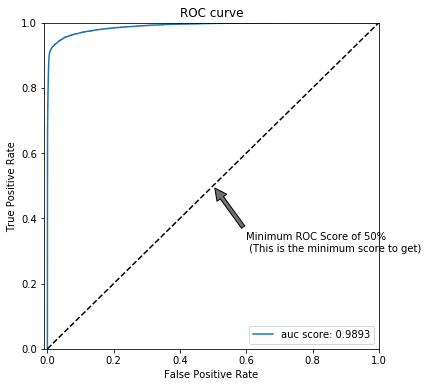

In [ ]:
plot_roc_auc_curve(g_y_vldt, g_y_pred_proba_vldt)

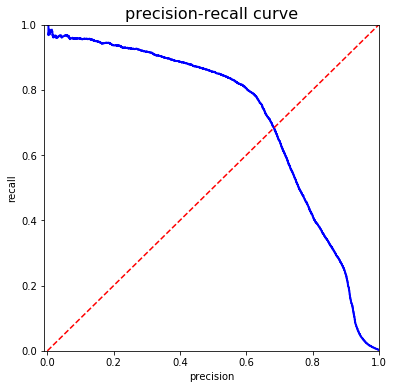

In [ ]:
plot_pr_curve(g_y_vldt, g_y_pred_proba_vldt)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(g_y_vldt, g_y_pred_label_vldt, target_names=['is_not_attributed','is_attributed'])
print(report)

                   precision    recall  f1-score   support

is_not_attributed       1.00      0.98      0.99   4990523
    is_attributed       0.09      0.93      0.16      9477

         accuracy                           0.98   5000000
        macro avg       0.54      0.96      0.58   5000000
     weighted avg       1.00      0.98      0.99   5000000



In [ ]:
from sklearn.metrics import precision_score
print(precision_score(g_y_vldt, g_y_pred_label_vldt))

0.08273803377484065


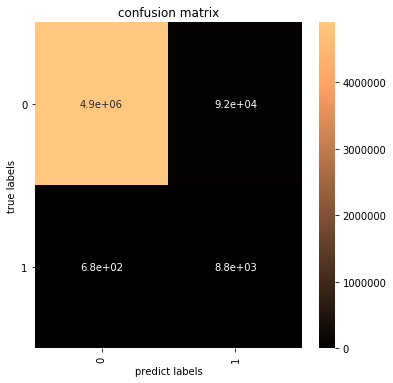

In [ ]:
plot_confusion_matrix(g_y_vldt, g_y_pred_label_vldt)

# Plot Features

functions for plotting features

> 用于评估特征的函数

```python
def plot_num_fea_distribution(df, categorical=g_categorical_features)
def headmap_plot_fea_target_corr_matrix(df, categorical = g_categorical_features)
def boxplot_of_fea_target_corr(df, categorical = g_categorical_features)```

In [ ]:
def headmap_plot_fea_target_corr_matrix(df, categorical = g_categorical_features):
    corr = df.drop(g_categorical_features, axis=1).corr()
    ax = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
    ax.set_title('Correlation Matrix \n', fontsize=14)
    plt.show(); g()

def plot_num_fea_distribution(df, categorical = g_categorical_features):
    feature_names = df.columns.values.tolist()
    for cat_fea_name in categorical + ['is_attributed']:
        if cat_fea_name in feature_names:
            feature_names.remove(cat_fea_name)
    print("numerical features: {}".format(feature_names))
    fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 36))
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=2)
    sns.color_palette("husl", 8)
    sns.set_style("white")
    sns.set_color_codes(palette='deep')
    for i, fea_name in enumerate(list(df[feature_names]), 1):
        plt.subplot(len(list(feature_names)), 2, i)
        sns.distplot(df[fea_name], fit=norm, color="b");  
        (mu, sigma) = norm.fit(df[fea_name]) 
        plt.legend([
            'Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)
        ],loc='best') 
        plt.xlabel('{}'.format(fea_name), size=15, labelpad=12.5)
        plt.ylabel("Frequency", size=15, labelpad=12.5)
        for j in range(2):
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)
        sns.despine(trim=True, left=True)
    plt.show(); g()

def boxplot_of_fea_target_corr(df, categorical = g_categorical_features):
    feature_names = df.columns.values.tolist()
    if 'is_attributed' in feature_names:
        feature_names.remove('is_attributed')
    print("feature_count: {}".format(len(feature_names))) 
    fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 36))
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=2)
    sns.color_palette("husl", 8)
    for i, fea_name in enumerate(list(df[feature_names]), 1):
        if fea_name.startswith("cumcount_"):
            outlier_plot_threshold = 18
            df.loc[df[fea_name]>outlier_plot_threshold, (fea_name)] = outlier_plot_threshold
        plt.subplot(len(list(feature_names)), 2, i)
        if fea_name in categorical:
            #sns.countplot(x=fea_name, hue='is_attributed', data=df)
            sns.violinplot(y=fea_name, x='is_attributed', data=df)
        else:
            sns.boxplot(y=fea_name, x='is_attributed', data=df)
        plt.xlabel('{}'.format('is_attributed'), size=15, labelpad=12.5)
        plt.ylabel(fea_name, size=15, labelpad=12.5)
        for j in range(2):
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)
        plt.legend(loc='best', prop={'size': 10})
    plt.show(); g()

plot feature importance

> 评估特征在lightgbm模型训练过程中的重要程度

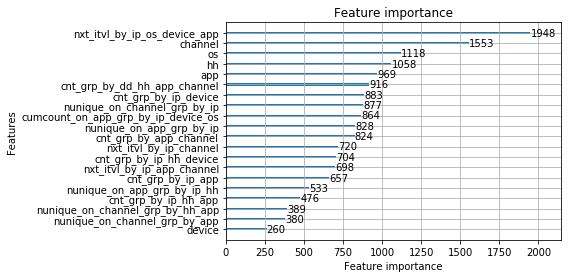

In [ ]:
lgb.plot_importance(g_model_fitted.booster_, importance_type='split')

<p>need a down-sampled data set to plot features, this has 2 benifits: </p>
1. virtualizing effect of both majority examples and minority examples: if no down-sampling, almost all input to plotting functions will be majority examples
2. it is more close with the model training input, which is also down-sampled

> 需要一个降采样之后的数据集来可视化特征分布：一方面不平衡数据集会导致可视化无法体现正例负例之间的差异（送给可视化函数的特征几乎全部都是负例(majority examples))；另一方面降采样是的可视化结果与模型训练一致（用于训练模型的特征也是经过降采样的特征）

In [ ]:
df_plot = random_down_sample(
                g_X_vldt.merge(g_y_vldt, left_index=True, right_index=True), 
                majority_multiply=g_majority_multiply, target_col_name='is_attributed', 
                minority_val = 1, majority_val = 0); g()
df_plot['is_attributed'].value_counts()

unreachable_obj_found: 7415


1    9477
0    9477
Name: is_attributed, dtype: int64

plot features, including feature distribution, 

numerical features: ['nxt_itvl_by_ip_os_device_app', 'cnt_grp_by_dd_hh_app_channel', 'cumcount_on_app_grp_by_ip_device_os', 'cnt_grp_by_ip_device', 'nunique_on_channel_grp_by_ip', 'nunique_on_app_grp_by_ip', 'nxt_itvl_by_ip_channel', 'cnt_grp_by_ip_hh_device', 'nxt_itvl_by_ip_app_channel', 'cnt_grp_by_app_channel', 'cnt_grp_by_ip_app', 'nunique_on_app_grp_by_ip_hh', 'cnt_grp_by_ip_hh_app', 'nunique_on_channel_grp_by_app', 'nunique_on_channel_grp_by_hh_app']


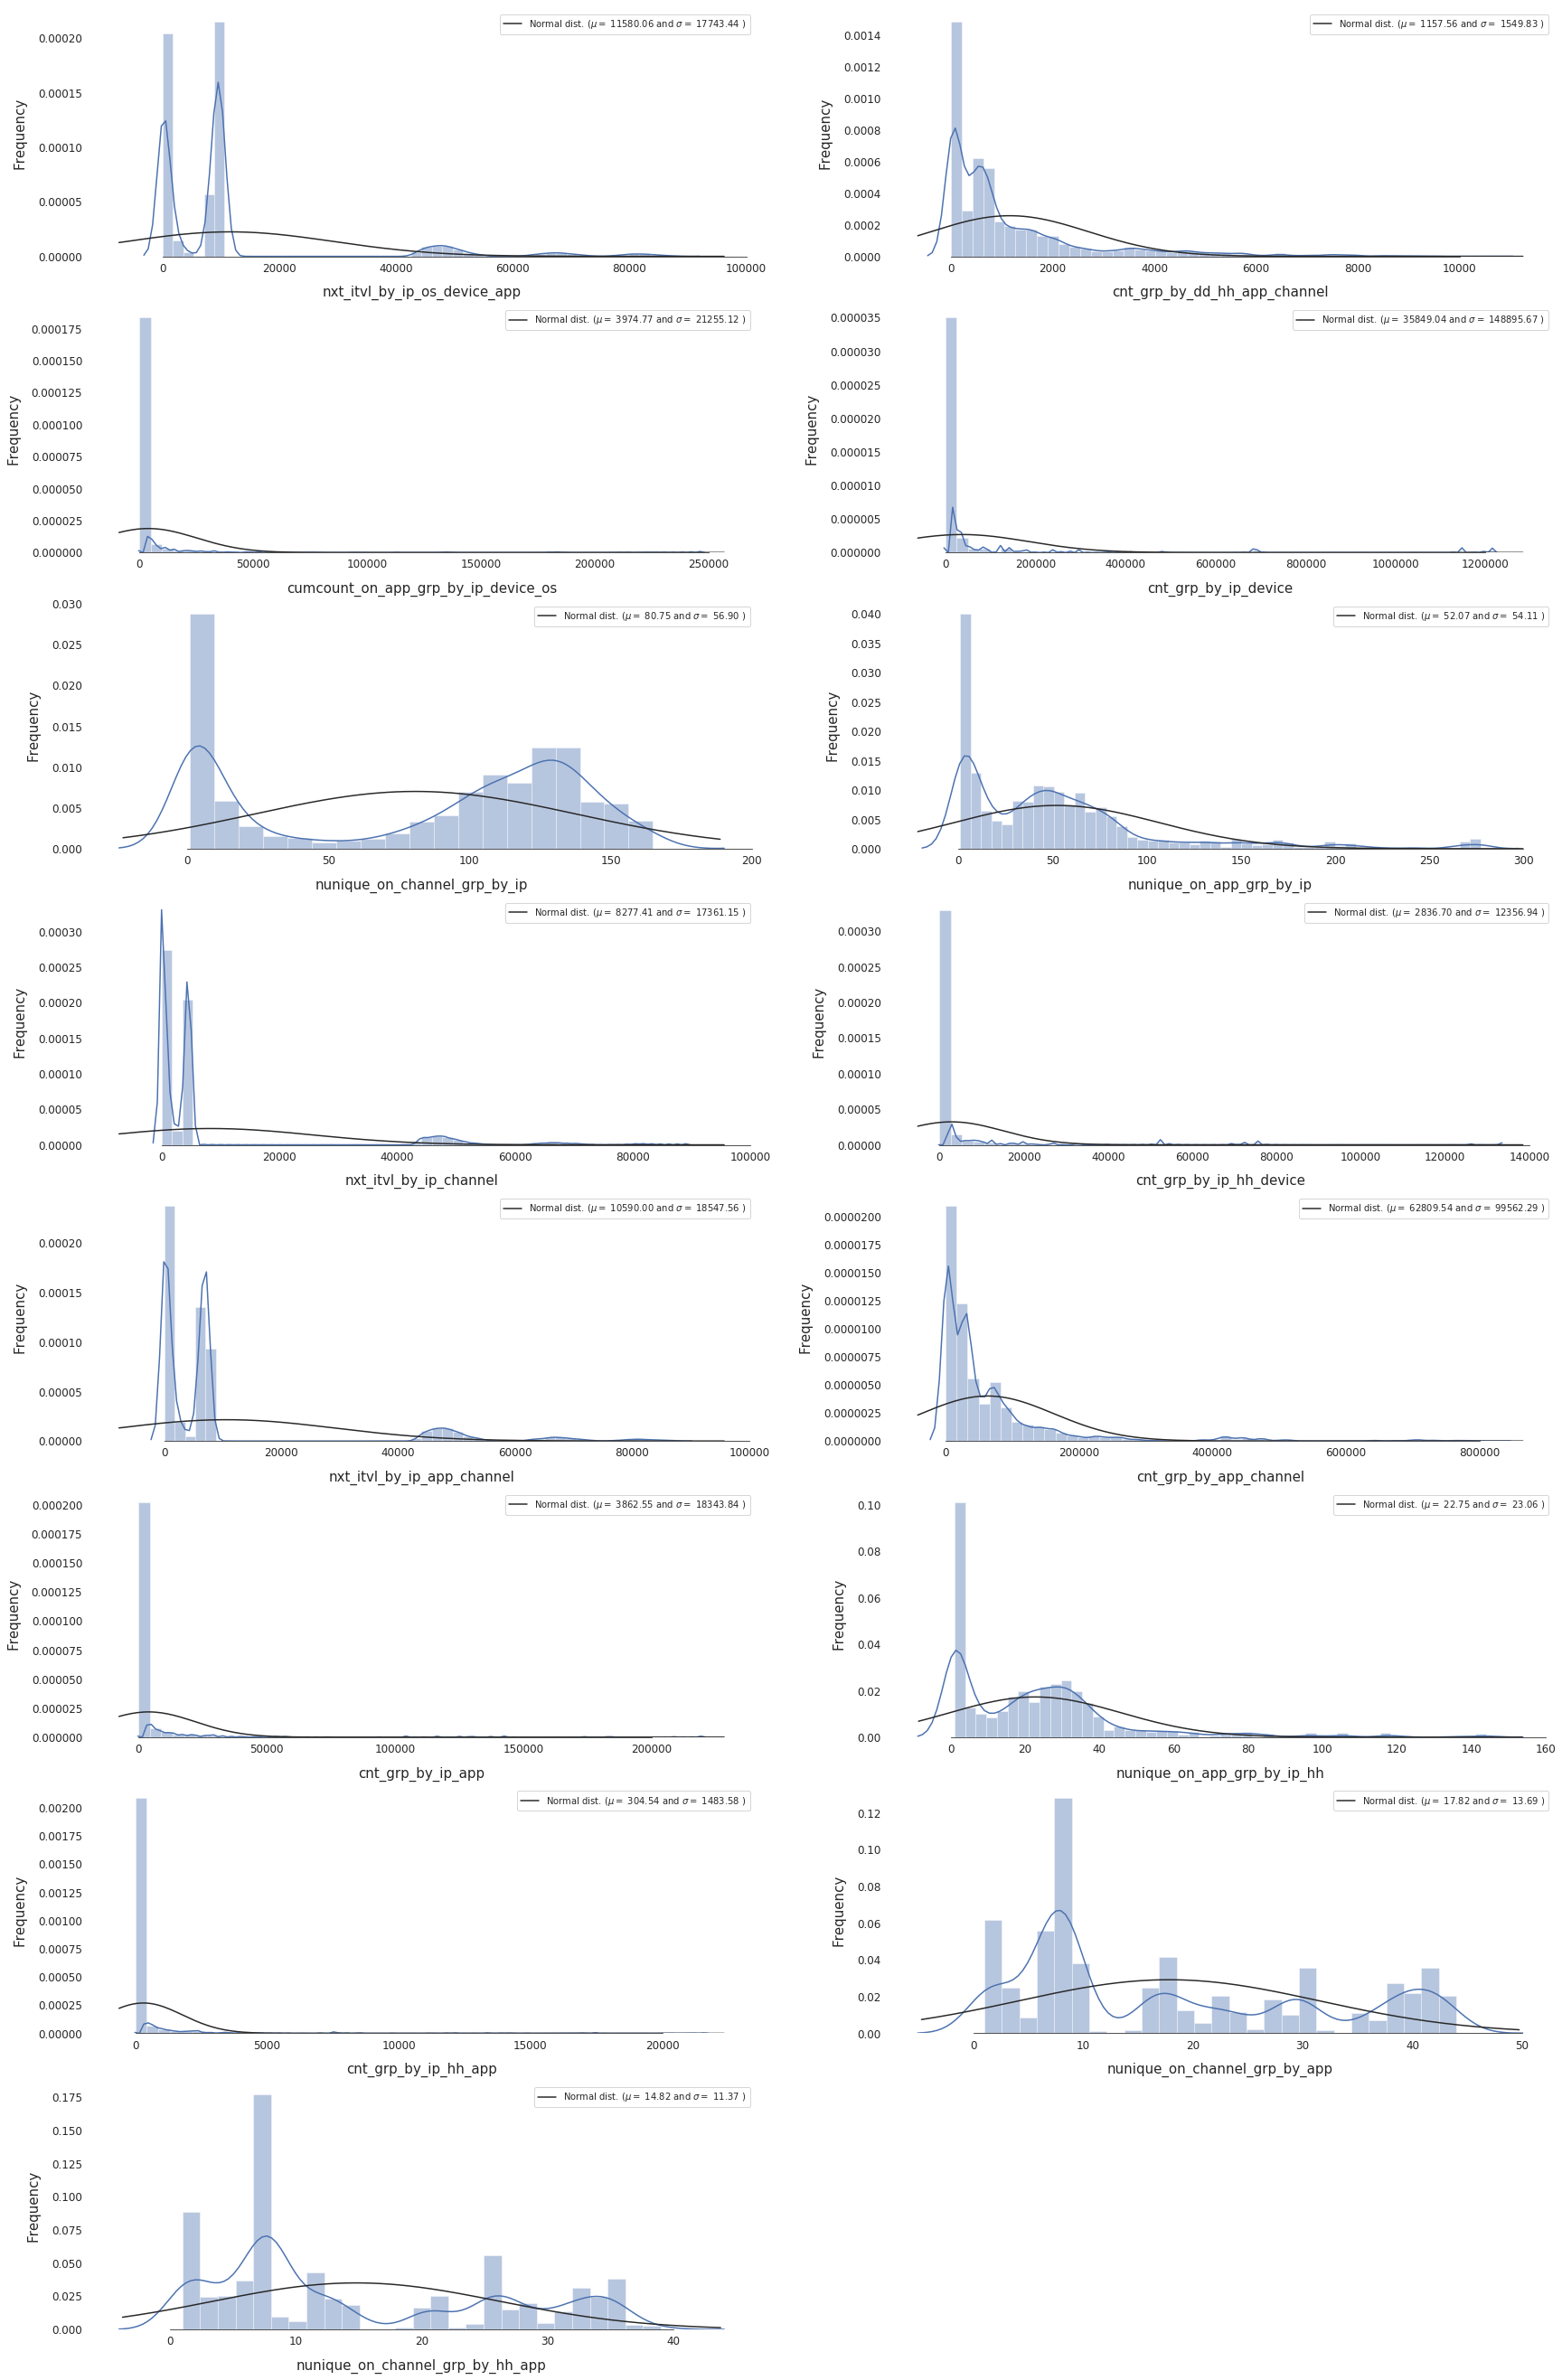

In [ ]:
plot_num_fea_distribution(df_plot)

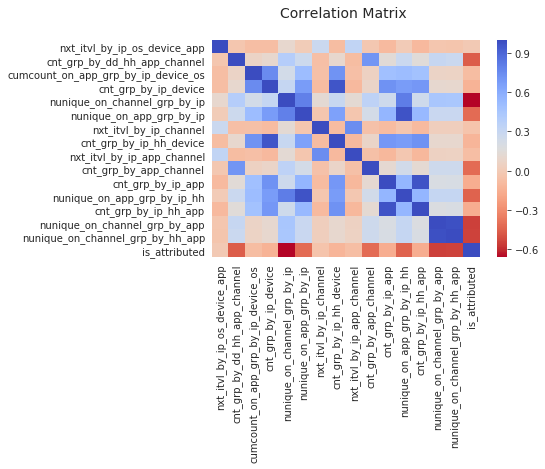

In [ ]:
headmap_plot_fea_target_corr_matrix(df_plot)

feature_count: 20


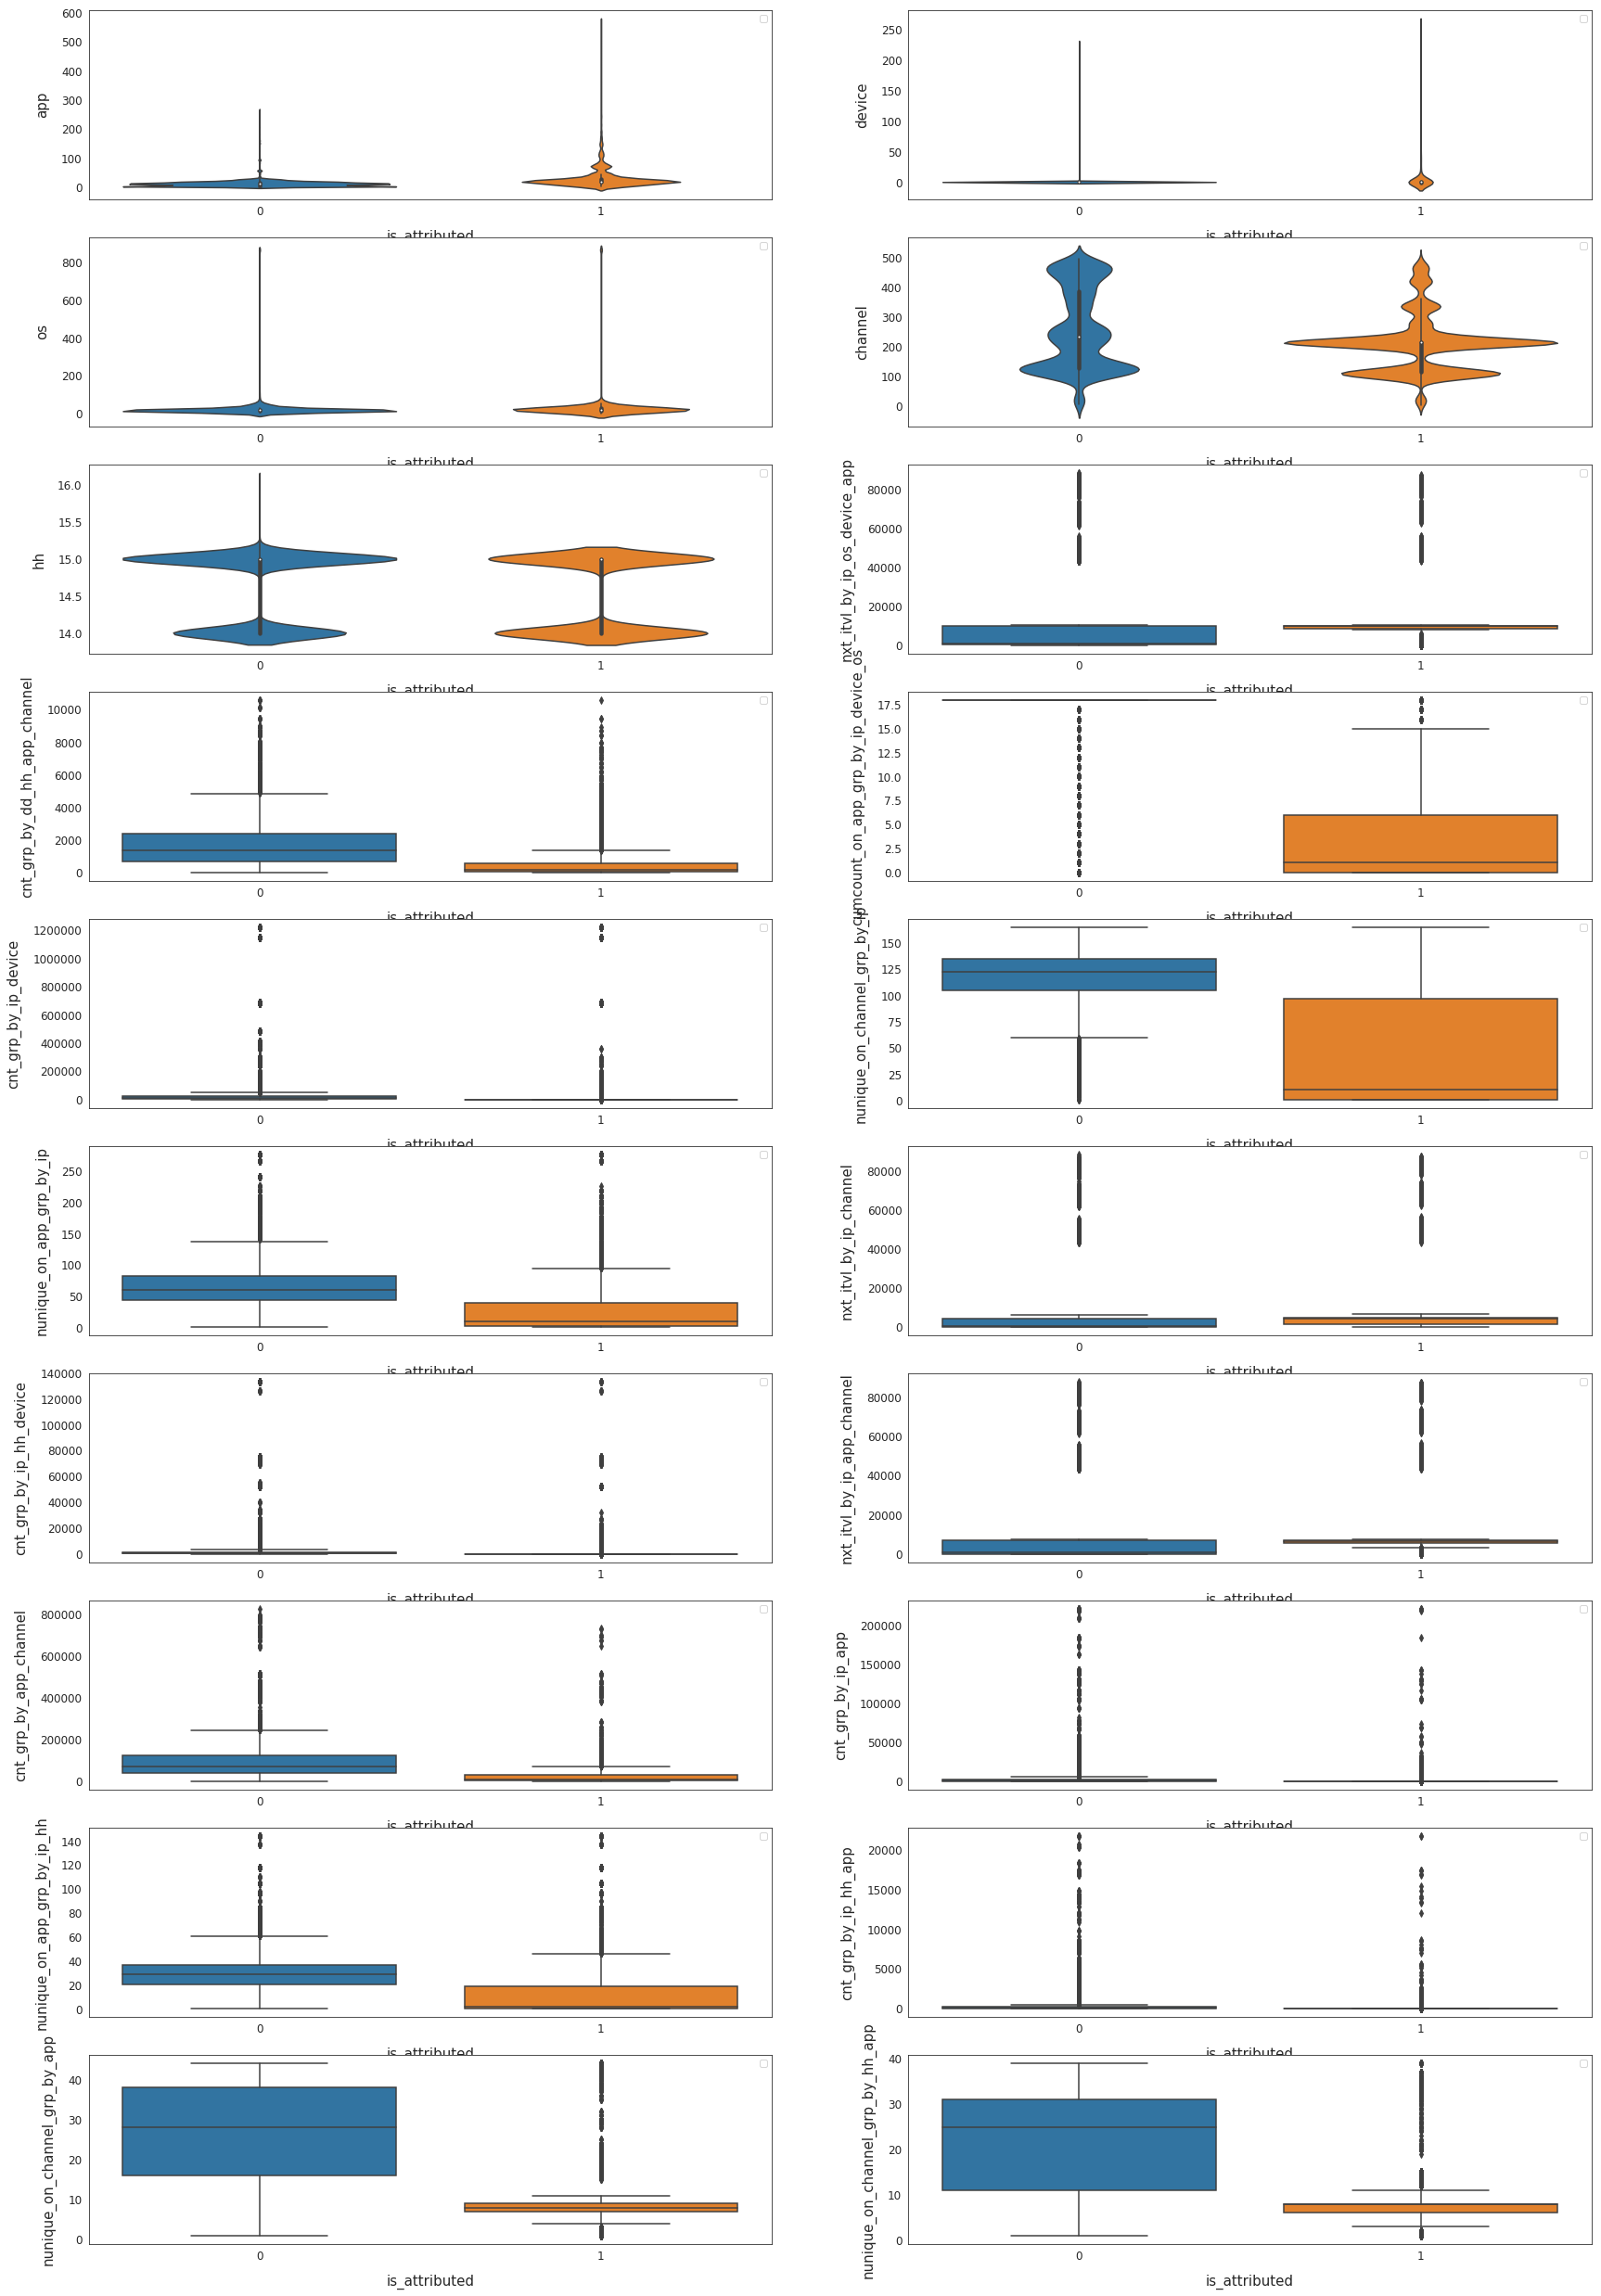

unreachable_obj_found: 45045


In [ ]:
boxplot_of_fea_target_corr(df_plot)
delete(df_plot)

# Training Analysis

Memory: 3.03GB
plot_metric_auc done in 0s


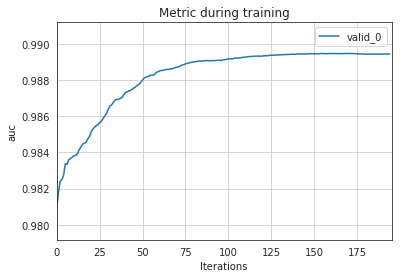

In [ ]:
with timer_memory('plot_metric_auc'):
    lgb.plot_metric(g_model_fitted, 'auc')

```python
def plot_learning_curve(model, X, y, cv, ylim=None, n_jobs=-1, train_sizes=np.array([0.1,0.5,0.75,1])):```

In [ ]:
def plot_learning_curve(model, X, y, cv, ylim=None, n_jobs=-1, train_sizes=np.array([0.1,0.5,0.75,1])):
    import matplotlib.pyplot as plt
    from sklearn.model_selection import learning_curve
    fig, ax = plt.subplots(1, 1,figsize=(10,6))
    if ylim is not None:
        plt.ylim(*ylim)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, shuffle=False, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax.fill_between(train_sizes, test_scores_mean  - test_scores_std,  test_scores_mean  + test_scores_std, alpha=0.1, color="#2492ff")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax.plot(train_sizes, test_scores_mean,  'o-', color="#2492ff", label="Cross-validation score")
    ax.set_title("Learning Curve", fontsize=14)
    ax.set_xlabel('Training size (m)')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc="best")
    plt.show()

from sklearn.model_selection import PredefinedSplit
def get_cv_splitter(y_train:pd.Series):
    total_size, test_size = y_train.size, y_train.size // 10
    test_fold = np.full(shape=(total_size,), fill_value=-1, dtype='int')
    test_fold[-1*test_size:] = 0
    cv = PredefinedSplit(test_fold=test_fold)
    print(f'total_size={total_size}; test_size={test_size}')
    return cv

In [ ]:
#with timer_memory('plot_learning_curve'):
#    plot_learning_curve(g_base_model, X=X_train, y=y_train, cv=get_cv_splitter(y_train), ylim=(0.92, 1.01), scoring='roc_auc')

# Grid Search

<p>existing function used: </p>

```python
g_base_models = {
    'gbdt_base_001' : gbtd_base_001(), ...
}
g_search_params = {
    # 'gbdt_base_001_exp_001' : {'num_leaves':[90, 95, 100, 105]},   # 105
    # 'gbdt_base_001_exp_003' : {'learning_rate':[0.1, 0.08, 0.06]}, # 0.8 is the best
    # 'gbdt_base_001_exp_004' : {'max_bin':[255, 315]},              # no difference
    'gbdt_base_001_exp_002' : {'min_sum_hessian_in_leaf':[0.001, 0.01, 0.05, 0.1]}, 
    'gbdt_base_001_exp_005' : {'min_split_gain':[0.3, 0.4, 0.5]},
    'gbdt_base_001_exp_010' : {'num_leaves':[90,105], 'min_split_gain':[0.3,0.4]}
}
def get_model_and_search_params(base_model_id, search_params_id)
def update_data_balancing_param(lgb_model, y_value_counts, majority_val=0, minority_val=1)
```

<p>new function defined as belows: </p>
```python
def grid_search(X_train, y_train, X_vldt, y_vldt, base_model, param_grid)```
<p><b>parameters turning:</b></p>
* [https://lightgbm.readthedocs.io/en/latest/Features.html#leaf-wise-best-first-tree-growth](https://lightgbm.readthedocs.io/en/latest/Features.html#leaf-wise-best-first-tree-growth)
* [https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

def grid_search(X_train, y_train, X_vldt, y_vldt, base_model, param_grid):
    # result
    estimator_lst,grid_point_lst,precision_lst,recall_lst,f1_lst,auc_lst=[],[],[],[],[],[]
    # grid search
    for grid_point in list(ParameterGrid(param_grid)):
        # model parameters
        print(f'----- grid_point: \n{grid_point}')
        base_model = base_model.set_params(**grid_point)
        base_model = base_model.set_params(silent = True)
        base_model = base_model.set_params(verbosity = 0)
        print('update_data_balancing_param:' )
        base_model = update_data_balancing_param(base_model, y_train.value_counts())
        print(f'model parameters: \n{base_model.get_params()}')
        # fit parameters
        print('cat_fea: {}'.format(g_fit_params['categorical_feature']))
        print('fea: {}'.format(X_train.columns))
        print(type(X_train.columns))
        print(X_train.columns.get_loc('app'))
        cat_fea_indices = list(map(lambda col:X_train.columns.get_loc(col), g_fit_params['categorical_feature']))
        fit_params_copy = g_fit_params.copy()
        fit_params_copy['categorical_feature'] = cat_fea_indices
        fit_params_copy['verbose'] = -1
        print(f'fit_params_copy: \n{fit_params_copy}')
        # fit
        fitted = base_model.fit(
            X_train, y_train, eval_set = [(X_vldt, y_vldt)], **fit_params_copy); g()
        # pred
        y_pred = fitted.predict(X_vldt)
        # append_score
        grid_point_lst.append(grid_point)        
        estimator_lst.append(fitted)
        precision_lst.append(precision_score(y_vldt, y_pred))
        recall_lst.append(recall_score(y_vldt, y_pred))
        f1_lst.append(f1_score(y_vldt, y_pred))
        auc_lst.append(roc_auc_score(y_vldt, y_pred))
    # search result
    score_dict = pd.DataFrame(data={
                        'precision':precision_lst,  # TP/(TP+FP)
                        'recall':recall_lst,        # TP/(TP+FN)
                        'f1':f1_lst,                # F1 Score
                        'auc':auc_lst               # AUC
                    }, index=grid_point_lst)
    estimator_dict = pd.DataFrame(data={'estimator':estimator_lst}, index=grid_point_lst)
    return score_dict, estimator_dict

def run_grid_search(base_model_id, exp_params_id): 
    with timer_memory('grid_search %'.format(exp_params_id)):
        lgb_model, search_params = get_model_and_search_params(base_model_id, exp_params_id)
        score_dict, estimator_dict = grid_search(X_train, y_train, g_X_vldt, g_y_vldt, lgb_model, search_params)
    return score_dict

Run Grid Search

In [ ]:
g_grid_search_results = {
    'gbdt_base_001_exp_002' : run_grid_search('gbdt_base_001', 'gbdt_base_001_exp_002'),
    'gbdt_base_001_exp_005' : run_grid_search('gbdt_base_001', 'gbdt_base_001_exp_005'),
    'gbdt_base_001_exp_010' : run_grid_search('gbdt_base_001', 'gbdt_base_001_exp_010')
}

def plot_grid_search_score(exp_id, grid_results=g_grid_search_results):
    grid_results[exp_id].plot.barh()
    return grid_results[exp_id]

----- grid_point: 
{'min_sum_hessian_in_leaf': 0.001}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.3, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 105, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.001, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'channel', 'hh']
fea: Index(['app', 'device', 'os', 'channel', 'hh', 'nxt_itvl_by_ip_os_device_app',
       'cnt_grp_by_dd_hh_app_channel', 'cumcount_on_app_grp_by_ip_device_os

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[170]	valid_0's auc: 0.989487
----- grid_point: 
{'min_sum_hessian_in_leaf': 0.01}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.3, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 105, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.01, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'channel', 'hh']
fea: Index(['app', 'device', 'os',

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[170]	valid_0's auc: 0.989487
----- grid_point: 
{'min_sum_hessian_in_leaf': 0.05}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.3, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 105, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.05, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'channel', 'hh']
fea: Index(['app', 'device', 'os',

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[191]	valid_0's auc: 0.989513
----- grid_point: 
{'min_sum_hessian_in_leaf': 0.1}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.3, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 105, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'channel', 'hh']
fea: Index(['app', 'device', 'os', '

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[216]	valid_0's auc: 0.989574
Memory: 3.76GB
grid_search % done in 1396s
----- grid_point: 
{'min_split_gain': 0.3}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.3, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 105, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'channel', 'hh']
fe

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[216]	valid_0's auc: 0.989574
----- grid_point: 
{'min_split_gain': 0.4}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.4, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 105, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'channel', 'hh']
fea: Index(['app', 'device', 'os', 'channel',

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[260]	valid_0's auc: 0.989595
----- grid_point: 
{'min_split_gain': 0.5}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.5, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 105, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'channel', 'hh']
fea: Index(['app', 'device', 'os', 'channel',

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[291]	valid_0's auc: 0.989458
Memory: 3.79GB
grid_search % done in 1363s
----- grid_point: 
{'min_split_gain': 0.3, 'num_leaves': 90}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.3, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 90, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'c

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[176]	valid_0's auc: 0.989397
----- grid_point: 
{'min_split_gain': 0.3, 'num_leaves': 105}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.3, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 105, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'channel', 'hh']
fea: Index(['app', 'device

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[216]	valid_0's auc: 0.989574
----- grid_point: 
{'min_split_gain': 0.4, 'num_leaves': 90}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.4, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 90, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'channel', 'hh']
fea: Index(['app', 'device',

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[215]	valid_0's auc: 0.989529
----- grid_point: 
{'min_split_gain': 0.4, 'num_leaves': 105}
update_data_balancing_param:
y_value_counts: 
1    447369
0    447369
Name: is_attributed, dtype: int64
majority_count/minority_count=1.0
model parameters: 
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.08, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.4, 'n_estimators': 2500, 'n_jobs': -1, 'num_leaves': 105, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.3, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'metric': 'auc', 'verbose': 1, 'nthread': 4, 'iid': False, 'two_round': True, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'verbosity': 0}
cat_fea: ['app', 'device', 'os', 'channel', 'hh']
fea: Index(['app', 'device

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[260]	valid_0's auc: 0.989595
Memory: 3.76GB
grid_search % done in 1439s


Grid Search Results

,precision,recall,f1,auc
{'min_sum_hessian_in_leaf': 0.001},0.087599,0.928669,0.160097,0.955150
{'min_sum_hessian_in_leaf': 0.01},0.087599,0.928669,0.160097,0.955150
{'min_sum_hessian_in_leaf': 0.05},0.088253,0.928142,0.161180,0.954966
{'min_sum_hessian_in_leaf': 0.1},0.090201,0.928142,0.164422,0.955182


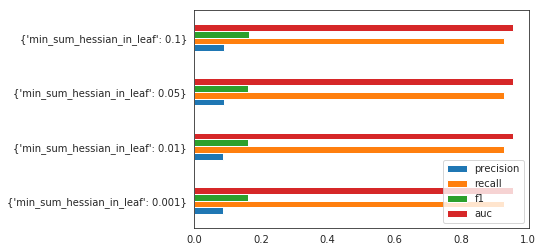

In [ ]:
plot_grid_search_score('gbdt_base_001_exp_002')

,precision,recall,f1,auc
{'min_split_gain': 0.3},0.090201,0.928142,0.164422,0.955182
{'min_split_gain': 0.4},0.087830,0.929725,0.160498,0.955694
{'min_split_gain': 0.5},0.084776,0.929830,0.155384,0.955384


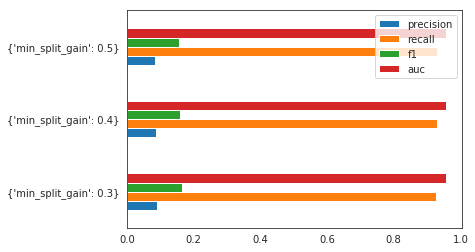

In [ ]:
plot_grid_search_score('gbdt_base_001_exp_005')

,precision,recall,f1,auc
"{'min_split_gain': 0.3, 'num_leaves': 90}",0.087663,0.928986,0.160208,0.955313
"{'min_split_gain': 0.3, 'num_leaves': 105}",0.090201,0.928142,0.164422,0.955182
"{'min_split_gain': 0.4, 'num_leaves': 90}",0.089005,0.929197,0.162450,0.955568
"{'min_split_gain': 0.4, 'num_leaves': 105}",0.087830,0.929725,0.160498,0.955694


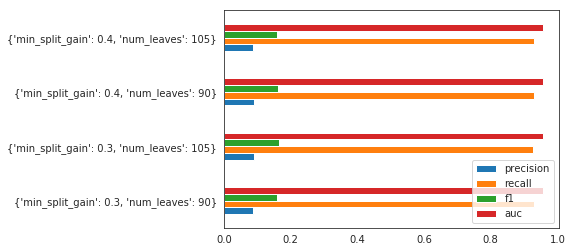

In [ ]:
plot_grid_search_score('gbdt_base_001_exp_010')